## Setup

In [1]:
import gc
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scienceplots
import seaborn as sns
from lobib import DataLoader
from lobib.utils import pl_select
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import FuncFormatter
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

import qr.estimations as est

sns.set_style("whitegrid")

loader = DataLoader()

HOURS_PER_DAY = 5.5
DAY_NS = int(5.5 * 3600 * 1e9)  # 5.5 hours in nanoseconds
HOUR_NS = int(3600 * 1e9)
TICK_TO_USD = 0.01
FIVE_MIN_NS = int(5 * 60 * 1e9)

plt.style.use(["science", "grid", "no-latex"])

In [2]:
def compute_volatility_sampled_empirical(
    df: pl.LazyFrame, sample_interval_ns: int = FIVE_MIN_NS
) -> pl.DataFrame:
    T = int(HOURS_PER_DAY * 3600e9 / sample_interval_ns)
    return (
        df.filter(pl.col("event") == "Trade")
        .with_columns(
            (pl.col("ts_event").dt.epoch("ns") // sample_interval_ns).alias(
                "time_bucket"
            )
        )
        .group_by(["date", "time_bucket"])
        .agg(pl.col("price").last())
        .sort(["date", "time_bucket"])
        .with_columns(
            (pl.col("price") * TICK_TO_USD).diff().over("date").alias("price_diff")
        )
        .filter(pl.col("price_diff").is_not_null())
        .group_by("date")
        .agg((pl.col("price_diff") ** 2).sum().alias("realized_var"))
        .with_columns(
            (pl.col("realized_var") / (T - 1)).sqrt().alias("volatility_per_hour")
        )
    )


def compute_volatility_sampled_simulation(
    df: pl.LazyFrame, sample_interval_ns: int = FIVE_MIN_NS
) -> pl.DataFrame:
    T = int(HOURS_PER_DAY * 3600e9 / sample_interval_ns)
    return (
        df.filter(pl.col("event") == "Trade")
        .with_columns(
            (pl.col("ts_event") // sample_interval_ns).alias("time_bucket"),
            (pl.col("ts_event") // DAY_NS).alias("date"),
        )
        .group_by(["date", "time_bucket"])
        .agg(pl.col("price").last())
        .sort(["date", "time_bucket"])
        .with_columns(
            (pl.col("price") * TICK_TO_USD).diff().over("date").alias("price_diff")
        )
        .filter(pl.col("price_diff").is_not_null())
        .group_by("date")
        .agg((pl.col("price_diff") ** 2).sum().alias("realized_var"))
        .with_columns(
            (pl.col("realized_var") / (T - 1)).sqrt().alias("volatility_per_hour")
        )
    )


def preprocess_sim(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns((pl.col("ts_event") // DAY_NS).alias("date"))
    df = df.filter(~pl.col("rejected"))
    df = df.filter(~(pl.col("event").eq("Add") & pl.col("partial")))
    df = df.with_columns(pl.col("ts_event").diff().alias("dt"))
    condlist = [
        *[
            pl.col("imbalance").ge(left) & pl.col("imbalance").lt(right)
            for left, right in zip(-est.BINS[1:][::-1], -est.BINS[:-1][::-1])
        ],
        pl.col("imbalance").eq(0),
        *[
            pl.col("imbalance").gt(left) & pl.col("imbalance").le(right)
            for left, right in zip(est.BINS[:-1], est.BINS[1:])
        ],
    ]
    choicelist = [*(-est.BINS[1:][::-1]), 0, *est.BINS[1:]]
    df = df.with_columns(imbalance=pl_select(condlist, choicelist))
    return df.drop_nulls()


def load_data(ticker: str) -> tuple[pl.DataFrame, pl.DataFrame]:
    files = list(Path(f"../data/{ticker}/daily_estimates").glob("*.parquet"))
    df = pl.scan_parquet(files)
    df = df.collect()
    dates = df["date"].unique().to_list()
    median_event_sizes, total_best_quantiles = est.load_params(
        f"../data/{ticker}/daily_estimates/params.json"
    )
    df_emp = pl.concat(
        [
            est.preprocess(
                loader.load(
                    ticker,
                    start_date=date,
                    end_date=date,
                    schema="qr",
                ),
                median_event_sizes,
                est.BINS,
                total_best_quantiles,
            )
            for date in dates
        ]
    )
    df_emp = df_emp.collect().sort("ts_event")

    return df, df_emp

In [3]:
ticker = "PFE"
df, df_emp = load_data(ticker)

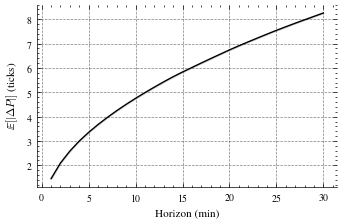

In [4]:
resample_ns = 500_000_000

df_rs = (
    df_emp.select("date", "ts_event", "mid")
    .with_columns((pl.col("ts_event").cast(pl.Int64) // resample_ns).alias("ts_bin"))
    .group_by("date", "ts_bin")
    .agg(pl.col("mid").last())
    .sort("date", "ts_bin")
)

horizons = list(range(120, 120 * 31, 120))  # 1 to 30 min (120 bins = 1 min at 500ms)

rows = []
for h in horizons:
    # Shift within each date
    dp = (
        df_rs.with_columns(
            (pl.col("mid").shift(-h).over("date") - pl.col("mid")).alias("dp")
        )
        .drop_nulls("dp")["dp"]
        .to_numpy()
    )
    abs_dp = np.abs(dp)
    n = len(abs_dp)
    rows.append((h * 0.5 / 60, abs_dp.mean(), abs_dp.std() / np.sqrt(n), n))

res = pl.DataFrame(
    rows,
    schema={
        "horizon_min": pl.Float64,
        "mean_abs_dp": pl.Float64,
        "se": pl.Float64,
        "n": pl.UInt32,
    },
    orient="row",
)

fig, ax = plt.subplots(figsize=(3.375, 2.2))
h = res["horizon_min"].to_numpy()
m = res["mean_abs_dp"].to_numpy()
se = res["se"].to_numpy()
ax.plot(h, m, color="black", lw=1)
ax.fill_between(h, m - 2 * se, m + 2 * se, color="black", alpha=0.15)
ax.set_xlabel("Horizon (min)", fontsize=8)
ax.set_ylabel(r"$\mathbb{E}[|\Delta P|]$ (ticks)", fontsize=8)
ax.tick_params(labelsize=7)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout(pad=0.2)
plt.show()

## QR Parameters

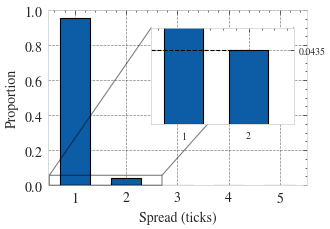

In [7]:
spread_dist = (
    df_emp.filter(pl.col("event").eq("Trade"))
    .select(pl.col("spread").value_counts(normalize=True))
    .unnest("spread")
    .sort("spread")
    .filter(pl.col("spread") <= 5)
)
spreads = spread_dist["spread"].to_numpy()
props = spread_dist["proportion"].to_numpy()
val_2 = props[spreads == 2][0]

fig, ax = plt.subplots(figsize=(3.5, 2.5))
ax.bar(spreads, props, width=0.6, edgecolor="k", linewidth=0.8)
ax.set_xticks(spreads)
ax.set_ylim(0, 1)
ax.set_xlabel("Spread (ticks)")
ax.set_ylabel("Proportion")

# Inset zoom
axins = ax.inset_axes([0.4, 0.35, 0.55, 0.55])
axins.bar(spreads, props, width=0.6, edgecolor="k", linewidth=0.8)
axins.set_xlim(0.5, 2.7)
axins.set_ylim(0, val_2 * 1.3)
axins.set_xticks([1, 2])
axins.hlines(val_2, axins.get_xlim()[0], 2, linestyles="--", colors="k", linewidth=0.8)
axins.set_yticks([val_2])
axins.yaxis.tick_right()
axins.set_yticklabels([f"{val_2:.4f}"], fontsize=16)
axins.tick_params(labelsize=7)

# Connect zoom region to inset
ax.indicate_inset_zoom(axins, edgecolor="k", linewidth=0.8)

fig.tight_layout()
plt.show()
# fig.savefig("../paper/spread_before_trades_pfe.pdf", bbox_inches="tight")

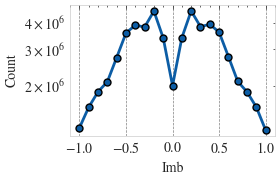

In [23]:
count = df.group_by("imbalance").agg(pl.col("len").sum()).sort("imbalance")
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(
    count["imbalance"],
    count["len"],
    marker="o",
    mec="k",
    ms=5,
    lw=2,
)
ax.set_xlabel("Imb")
ax.set_ylabel("Count")
ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
ax.set_yscale("log")
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
fig.tight_layout()
plt.show()
# fig.savefig("../paper/imb_count_PFE.pdf", bbox_inches="tight")

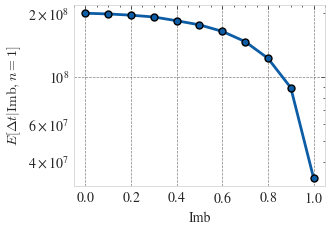

In [27]:
delta_t = est.exp_delta_t(df.lazy())
fig, ax = plt.subplots(figsize=(3.5, 2.5))
ax.plot(
    delta_t.filter(pl.col("spread").eq(1))["imbalance"],
    delta_t.filter(pl.col("spread").eq(1))["average_dt"],
    marker="o",
    mec="k",
    ms=5,
    lw=2,
)
ax.set_xlabel("Imb")
ax.set_ylabel(r"$E[\Delta t | \text{Imb}, n=1]$")
ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
ax.set_yscale("log")
fig.tight_layout()
plt.show()
# fig.savefig("../paper/avg_delta_t_PFE.pdf", bbox_inches="tight")

In [21]:
probabilities = pl.read_csv(f"../data/{ticker}/qr_params/event_probabilities.csv")

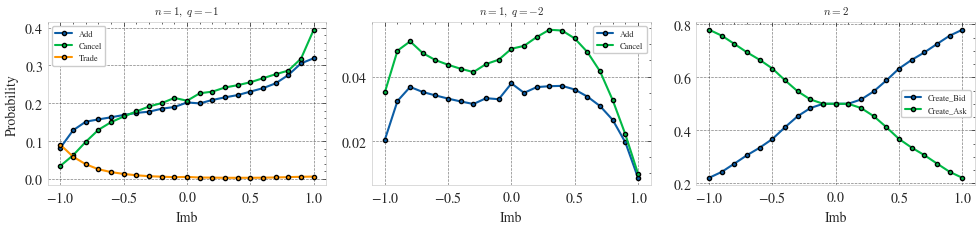

In [22]:
probs = pl.concat(
    [
        probabilities.filter(pl.col("imbalance").ne(0)).with_columns(
            imbalance=-pl.col("imbalance"),
            side=-pl.col("side"),
            queue=-pl.col("queue"),
            event=pl.col("event").replace(
                {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
            ),
        ),
        probabilities,
    ]
).sort("imbalance", "spread", "event", "queue")


fig, axes = plt.subplots(1, 3, figsize=(10, 2.5))

configs = [
    (1, -1, ["Add", "Cancel", "Trade"], r"$n=1,\; q=-1$"),
    (1, -2, ["Add", "Cancel"], r"$n=1,\; q=-2$"),
    (2, 0, ["Create_Bid", "Create_Ask"], r"$n=2$"),
]

for ax, (spread, queue, events, title) in zip(axes, configs):
    if queue != 0:
        sub = probs.filter(pl.col("spread").eq(spread) & pl.col("queue").eq(queue))
    else:
        sub = probs.filter(pl.col("spread").eq(spread))
    for event in events:
        data = sub.filter(pl.col("event").eq(event)).sort("imbalance")
        ax.plot(
            data["imbalance"],
            data["probability"],
            marker="o",
            ms=3,
            lw=1.5,
            label=event,
            mec="k",
        )
    ax.set_xlabel("Imb")
    ax.set_title(title, fontsize=8)
    ax.legend(fontsize=6)

axes[0].set_ylabel("Probability")
fig.tight_layout()
plt.show()

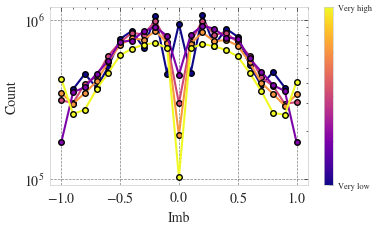

In [11]:
norm = mcolors.Normalize(vmin=0, vmax=4)
cmap = cm.plasma

stats = (
    df.group_by("imbalance", "spread", "total_best")
    .agg(pl.col("delta_t_sum").sum() / pl.col("len").sum(), pl.col("len").sum())
    .sort("imbalance")
)

fig, ax = plt.subplots(figsize=(4, 2.5))
for (total_best,), data in stats.filter(pl.col("spread").eq(1)).group_by("total_best"):
    ax.plot(
        data["imbalance"],
        data["len"],
        marker="o",
        ms=4,
        lw=1.5,
        mec="k",
        color=cmap(norm(total_best)),
    )
ax.set_xlabel("Imb")
ax.set_ylabel("Count")
ax.set_yscale("log")

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, ticks=[0, 4])
cbar.ax.set_yticklabels(["Very low", "Very high"], fontsize=6)

fig.tight_layout()
plt.show()
# fig.savefig("../paper/count_imb_total_best_PFE.pdf", bbox_inches="tight")

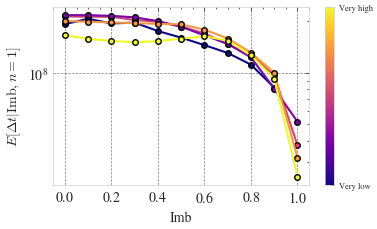

In [13]:
stats = (
    df.group_by(pl.col("imbalance").abs(), "spread", "total_best")
    .agg(pl.col("delta_t_sum").sum() / pl.col("len").sum(), pl.col("len").sum())
    .sort("imbalance")
)

fig, ax = plt.subplots(figsize=(4, 2.5))
for (total_best,), data in stats.filter(pl.col("spread").eq(1)).group_by("total_best"):
    ax.plot(
        data["imbalance"],
        data["delta_t_sum"],
        marker="o",
        ms=4,
        lw=1.5,
        mec="k",
        color=cmap(norm(total_best)),
    )
ax.set_xlabel("Imb")
ax.set_ylabel(r"$E[\Delta t | \text{Imb}, n=1]$")
ax.set_yscale("log")

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, ticks=[0, 4])
cbar.ax.set_yticklabels(["Very low", "Very high"], fontsize=6)

fig.tight_layout()
plt.show()
# fig.savefig("../paper/avg_delta_t_total_best_PFE.pdf", bbox_inches="tight")

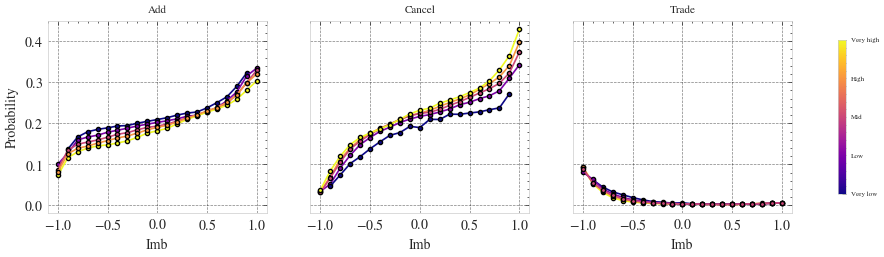

In [14]:
stats = (
    df.group_by("imbalance", "spread", "total_best", "queue", "side", "event")
    .agg(pl.col("len").sum(), pl.col("delta_t_sum").sum())
    .with_columns(
        total_len_cat=pl.col("len").sum().over("imbalance", "spread", "total_best")
    )
)

probabilities_3d = stats.select(
    "imbalance",
    "spread",
    "total_best",
    "queue",
    "side",
    "event",
    probability=pl.col("len").truediv(pl.col("total_len_cat")),
).sort("imbalance", "spread", "total_best", "queue", "side", "event")

pos = probabilities_3d.filter(pl.col("imbalance") >= 0)
neg = probabilities_3d.filter(pl.col("imbalance") <= 0).with_columns(
    imbalance=-pl.col("imbalance"),
    side=-pl.col("side"),
    queue=-pl.col("queue"),
    event=pl.col("event").replace(
        {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
    ),
)

probabilities_3d = (
    pl.concat([pos, neg])
    .group_by("imbalance", "spread", "total_best", "event", "queue", "side")
    .agg(
        probability=pl.col("probability").mean(),
    )
)

probabilities_3d = probabilities_3d.sort(
    "imbalance", "spread", "total_best", "event", "queue"
)

probs = pl.concat(
    [
        probabilities_3d.filter(pl.col("imbalance").ne(0)).with_columns(
            imbalance=-pl.col("imbalance"),
            side=-pl.col("side"),
            queue=-pl.col("queue"),
            event=pl.col("event").replace(
                {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
            ),
        ),
        probabilities_3d,
    ]
).sort("imbalance", "spread", "event", "queue")
probs = probs.filter(pl.col("spread").eq(1) & pl.col("queue").eq(-1))

probs_bid = probs.filter(pl.col("spread").eq(1) & pl.col("queue").eq(-1))

fig, axes = plt.subplots(1, 3, figsize=(12, 2.5), sharey=True)

for ax, event in zip(axes, ["Add", "Cancel", "Trade"]):
    data = probs_bid.filter(pl.col("event").eq(event))
    for (tb,), group in data.group_by("total_best"):
        group = group.sort("imbalance")
        ax.plot(
            group["imbalance"],
            group["probability"],
            marker="o",
            ms=3,
            lw=1.2,
            mec="k",
            color=cmap(norm(tb)),
        )
    ax.set_xlabel("Imb")
    ax.set_title(event, fontsize=8)

axes[0].set_ylabel("Probability")

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axes, ticks=[0, 1, 2, 3, 4], shrink=0.8)
cbar.ax.set_yticklabels(["Very low", "Low", "Mid", "High", "Very high"], fontsize=5)

# fig.tight_layout()
plt.show()
# fig.savefig("../paper/probabilities_total_best_PFE.pdf", bbox_inches="tight")

In [41]:
df = df.with_columns(pl.col("date").cast(pl.Date))

# Create a period label based on 6-month intervals
df = df.with_columns(
    (
        pl.col("date").dt.year().cast(pl.Utf8)
        + "_H"
        + ((pl.col("date").dt.month() - 1) // 6 + 1).cast(pl.Utf8)
    ).alias("period")
)

# Split into a dict of DataFrames keyed by period
periods = dict(
    sorted(
        ((name[0], group) for name, group in df.group_by("period")), key=lambda x: x[0]
    )
)

In [43]:
probabilities = {
    name: est.event_probabilities(period.lazy())
    for name, period in periods.items()
    if name != "2023_H2"
}
delta_t = {
    name: est.exp_delta_t(period.lazy())
    for name, period in periods.items()
    if name != "2023_H2"
}

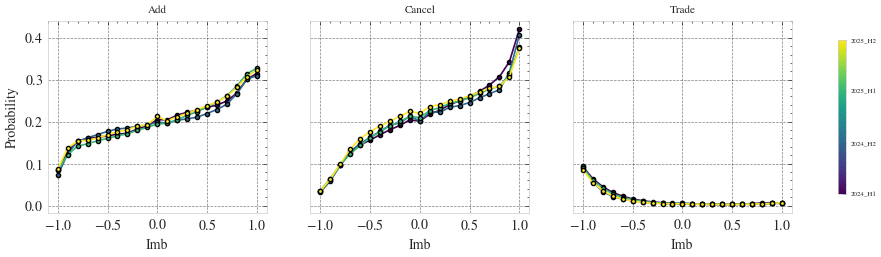

In [47]:
# Combine all periods into one DataFrame with a "period" column
probs_all = pl.concat(
    [p.with_columns(pl.lit(name).alias("period")) for name, p in probabilities.items()]
)

# Symmetrize (same logic, just without total_best)
pos = probs_all.filter(pl.col("imbalance") >= 0)
neg = probs_all.filter(pl.col("imbalance") <= 0).with_columns(
    imbalance=-pl.col("imbalance"),
    side=-pl.col("side"),
    queue=-pl.col("queue"),
    event=pl.col("event").replace(
        {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
    ),
)

probs_sym = (
    pl.concat([pos, neg])
    .group_by("imbalance", "spread", "event", "queue", "side", "period")
    .agg(probability=pl.col("probability").mean())
)

# Mirror to negative imbalances
probs_full = pl.concat(
    [
        probs_sym.filter(pl.col("imbalance").ne(0)).with_columns(
            imbalance=-pl.col("imbalance"),
            side=-pl.col("side"),
            queue=-pl.col("queue"),
            event=pl.col("event").replace(
                {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
            ),
        ),
        probs_sym,
    ]
).sort("imbalance", "spread", "event", "queue", "period")

probs_bid = probs_full.filter(pl.col("spread").eq(1) & pl.col("queue").eq(-1))

# Plot
sorted_periods = sorted(probs_bid["period"].unique().to_list())
norm = mcolors.Normalize(vmin=0, vmax=len(sorted_periods) - 1)
cmap = cm.viridis  # or your preferred colormap

fig, axes = plt.subplots(1, 3, figsize=(12, 2.5), sharey=True)

for ax, event in zip(axes, ["Add", "Cancel", "Trade"]):
    data = probs_bid.filter(pl.col("event").eq(event))
    for i, period in enumerate(sorted_periods):
        group = data.filter(pl.col("period").eq(period)).sort("imbalance")
        ax.plot(
            group["imbalance"],
            group["probability"],
            marker="o",
            ms=3,
            lw=1.2,
            mec="k",
            color=cmap(norm(i)),
            label=period,
        )
    ax.set_xlabel("Imb")
    ax.set_title(event, fontsize=8)

axes[0].set_ylabel("Probability")

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axes, ticks=range(len(sorted_periods)), shrink=0.8)
cbar.ax.set_yticklabels(sorted_periods, fontsize=5)
# fig.savefig("../paper/probabilities_over_time_PFE.pdf", bbox_inches="tight")
plt.show()

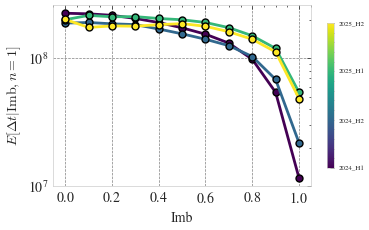

In [48]:
sorted_periods = sorted(delta_t.keys())
norm = mcolors.Normalize(vmin=0, vmax=len(sorted_periods) - 1)
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(4, 2.5))
for i, period in enumerate(sorted_periods):
    data = delta_t[period].filter(pl.col("spread").eq(1)).sort("imbalance")
    ax.plot(
        data["imbalance"],
        data["average_dt"],
        marker="o",
        ms=5,
        lw=2,
        mec="k",
        color=cmap(norm(i)),
    )
ax.set_xlabel("Imb")
ax.set_ylabel(r"$E[\Delta t | \text{Imb}, n=1]$")
ax.set_yscale("log")

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, ticks=range(len(sorted_periods)), shrink=0.8)
cbar.ax.set_yticklabels(sorted_periods, fontsize=5)
# fig.savefig("../paper/delta_t_over_time_PFE.pdf", bbox_inches="tight")
fig.tight_layout()
plt.show()

In [98]:
stats = df.group_by("imbalance", "spread", "queue", "side", "event").agg(
    pl.col("size").flatten()
)
pos = stats.filter(pl.col("imbalance") >= 0)
neg = stats.filter(pl.col("imbalance") <= 0).with_columns(
    imbalance=-pl.col("imbalance"),
    side=-pl.col("side"),
    queue=-pl.col("queue"),
    event=pl.col("event").replace(
        {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
    ),
)
sizes = (
    pl.concat([pos, neg])
    .group_by("imbalance", "spread", "event", "queue", "side")
    .agg(pl.col("size").flatten())
    .sort("imbalance", "spread", "event", "queue")
)

MAX_SIZE = 50

size_hist = (
    sizes.explode("size")
    .with_columns(pl.col("size").clip(1, MAX_SIZE))
    .group_by("imbalance", "spread", "event", "queue", "side", "size")
    .len()
    .with_columns(
        (
            pl.col("len")
            / pl.col("len").sum().over("imbalance", "spread", "event", "queue", "side")
        ).alias("prob")
    )
    .drop("len")
    .pivot(
        on="size",
        index=["imbalance", "spread", "event", "queue", "side"],
        values="prob",
    )
    .fill_null(0.0)
)

# Ensure all size columns 1..50 exist
for i in range(1, MAX_SIZE + 1):
    if str(i) not in size_hist.columns:
        size_hist = size_hist.with_columns(pl.lit(0.0).alias(str(i)))

key_cols = ["imbalance", "spread", "event", "queue", "side"]
size_cols = [str(i) for i in range(1, MAX_SIZE + 1)]
size_hist = size_hist.select(key_cols + size_cols).sort(
    "imbalance", "spread", "event", "queue"
)

## Empirical vs QR statistics

In [6]:
df_sim = pl.read_parquet(
    "/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/PFE/samples/fc92aebbfa13e94d.parquet"
)
df_sim = preprocess_sim(df_sim)

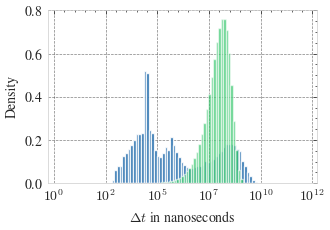

In [18]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))
ax.hist(
    df["delta_t"].explode().log10(),
    bins=80,
    density=True,
    label="Empirical",
    alpha=0.85,
)
ax.hist(
    df_sim.filter(pl.col("dt") > 0)["dt"].log10(),
    bins=80,
    density=True,
    label="QR",
    alpha=0.6,
)
ax.set_xlabel(r"$\Delta t$ in nanoseconds")
ax.set_ylabel("Density")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(x)}}}$"))
fig.tight_layout()
# fig.savefig("../paper/delta_t_exp_fit_PFE.pdf", bbox_inches="tight")
plt.show()

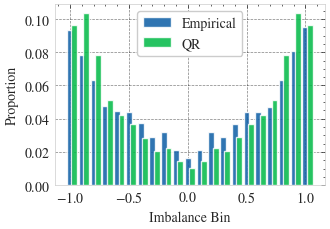

In [19]:
imb_dist = (
    df.filter(pl.col("event").eq("Trade"))
    .group_by("imbalance")
    .agg(pl.col("len").sum())
    .with_columns(proportion=pl.col("len") / pl.col("len").sum())
    .sort("imbalance")
)

imb_sim = (
    df_sim.filter(pl.col("event").eq("Trade"))["imbalance"]
    .value_counts(normalize=True)
    .sort("imbalance")
)


fig, ax = plt.subplots(figsize=(3.5, 2.5))

x = imb_dist["imbalance"]
width = 0.05

ax.bar(x, imb_dist["proportion"], width, label="Empirical", alpha=0.85)
ax.bar(x + width * 3 / 4, imb_sim["proportion"], width, label="QR", alpha=0.85)

ax.set_xlabel("Imbalance Bin")
ax.set_ylabel("Proportion")
ax.legend()
# ax.set_title(f"Binned imbalance distribution (before a trade) Ticker: {ticker}")
plt.tight_layout()
# fig.savefig("../paper/imb_distrib_before_trade_PFE.pdf", bbox_inches="tight")
plt.show()

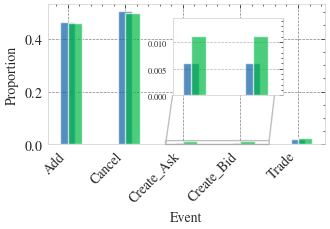

In [20]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

event_dist = (
    df.group_by("event")
    .agg(pl.col("len").sum())
    .with_columns(proportion=pl.col("len") / pl.col("len").sum())
    .sort("event")
)
event_dist_sim = df_sim["event"].value_counts(normalize=True).sort("event")

labels = event_dist["event"]
x = np.arange(len(labels))
width = 0.25

ax.bar(x, event_dist["proportion"], width, label="Empirical", alpha=0.7)
ax.bar(
    x + width / 2,
    event_dist_sim["proportion"],
    width,
    label="QR",
    alpha=0.7,
)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_xlabel("Event")
ax.set_ylabel("Proportion")
# ax.legend()

# Zoom patch on Create_Bid / Create_Ask region
create_idx = [i for i, l in enumerate(labels) if "Create" in l]
x1 = min(create_idx) - 0.3
x2 = max(create_idx) + 0.5
y1 = 0
y2 = (
    max(
        max(event_dist["proportion"][i] for i in create_idx),
        max(event_dist_sim["proportion"][i] for i in create_idx),
    )
    * 1.3
)

axins = ax.inset_axes([0.45, 0.35, 0.4, 0.55])
axins.bar(
    x[create_idx],
    [event_dist["proportion"][i] for i in create_idx],
    width,
    alpha=0.7,
)
axins.bar(
    x[create_idx] + width / 2,
    [event_dist_sim["proportion"][i] for i in create_idx],
    width,
    alpha=0.7,
)
axins.set_xticks([])
# axins.set_xticklabels([labels[i] for i in create_idx], fontsize=6, rotation=45, ha="right")
axins.tick_params(labelsize=6)
axins.grid(True, alpha=0.3)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

ax.indicate_inset_zoom(axins, edgecolor="grey", alpha=0.5)

plt.tight_layout()
# fig.savefig("../paper/emp_vs_qr_event_distrib_PFE.pdf", bbox_inches="tight")
plt.show()

In [21]:
bin_ns = int(5 * 60 * 1e9)  # 5 minutes in ns

returns_emp = (
    df_emp.with_columns((pl.col("ts_event").cast(pl.Int64) // bin_ns).alias("bin"))
    .group_by("date", "bin")
    .agg(pl.col("mid").last())
    .sort("date", "bin")
    .with_columns((pl.col("mid") - pl.col("mid").shift(1)).over("date").alias("ret_5m"))
    .drop_nulls("ret_5m")
)

returns_sim = (
    df_sim.with_columns((pl.col("ts_event") // bin_ns).alias("bin"))
    .group_by("date", "bin")
    .agg(pl.col("mid").last())
    .sort("date", "bin")
    .with_columns((pl.col("mid") - pl.col("mid").shift(1)).over("date").alias("ret_5m"))
    .drop_nulls("ret_5m")
)

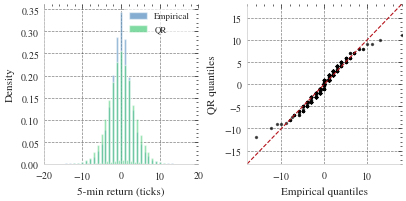

In [22]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(4, 2), gridspec_kw={"width_ratios": [1, 1]}
)

# --- Histogram ---
bins = np.linspace(-20, 20, 80)

ax1.hist(
    returns_emp["ret_5m"],
    bins=bins,
    density=True,
    alpha=0.5,
    color="C0",
    label="Empirical",
)
ax1.hist(
    returns_sim["ret_5m"],
    bins=bins,
    density=True,
    alpha=0.5,
    color="C1",
    label="QR",
)

ax1.set_xlim(-20, 20)
ax1.set_xlabel("5-min return (ticks)", fontsize=8)
ax1.set_ylabel("Density", fontsize=8)
ax1.tick_params(labelsize=7)
ax1.legend(fontsize=6.5, framealpha=0.7, edgecolor="none")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# --- QQ plot ---
q = np.linspace(0.001, 0.999, 500)
emp_q = np.quantile(returns_emp["ret_5m"].to_numpy(), q)
sim_q = np.quantile(returns_sim["ret_5m"].to_numpy(), q)

ax2.scatter(emp_q, sim_q, s=2, color="black", alpha=0.6)
lim = max(abs(emp_q.min()), abs(emp_q.max()), abs(sim_q.min()), abs(sim_q.max()))
ax2.plot([-lim, lim], [-lim, lim], "--", lw=0.8, color="#B5121B")
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

ax2.set_xlabel("Empirical quantiles", fontsize=8)
ax2.set_ylabel("QR quantiles", fontsize=8)
ax2.tick_params(labelsize=7)
# ax2.legend(fontsize=6.5, framealpha=0.7, edgecolor="none")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

fig.tight_layout(pad=0.3)
# fig.savefig("../paper/returns_5m_PFE.pdf", bbox_inches="tight", dpi=300)
plt.show()

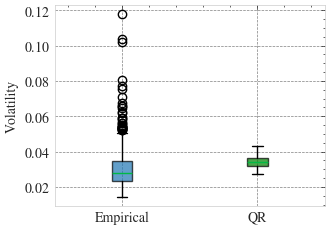

In [23]:
vol_emp = compute_volatility_sampled_empirical(df_emp)
vol_sim = compute_volatility_sampled_simulation(df_sim)

fig, ax = plt.subplots(figsize=(3.5, 2.5))

labels = ["Empirical", "QR"]
colors = ["tab:blue", "green"]

vol_data = [
    vol_emp["volatility_per_hour"].to_numpy(),
    vol_sim["volatility_per_hour"].to_numpy(),
]
bp = ax.boxplot(vol_data, tick_labels=labels, patch_artist=True)

for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel(r"Volatility")

plt.tight_layout()
# fig.savefig("../paper/volatility_5m_PFE.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_2639629/3299942859.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([sz, sze], labels=labels, patch_artist=True)


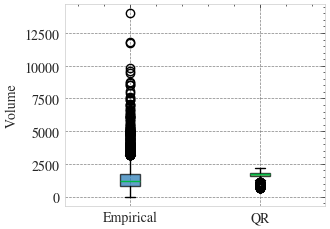

In [24]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

sz = (
    df_emp.filter(pl.col("event").eq("Trade"))
    .group_by(pl.col("date"), pl.col("ts_event").dt.hour())
    .agg(pl.col("size").sum())["size"]
)
sze = (
    df_sim.filter(pl.col("event").eq("Trade"))
    .group_by(pl.col("date"), pl.col("ts_event") // HOUR_NS)
    .agg(pl.col("size").sum())["size"]
)

labels = ["Empirical", "QR"]
colors = ["tab:blue", "tab:green"]

bp = ax.boxplot([sz, sze], labels=labels, patch_artist=True)

for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel(r"Volume")


plt.tight_layout()
# fig.savefig("../paper/hourly_traded_volume_PFE.pdf", bbox_inches="tight")
plt.show()

## Impact

In [26]:
import numpy as np
from scipy.optimize import nnls

tau = 50
K = 8
half_lives = np.logspace(-1, 2.7, K)
lambdas = np.log(2) / half_lives

t = np.logspace(-2, 5, 500)

# Steep component (controls rise) + slow tail (controls decay)
w_fast = 1
w_slow = 0
K_target = w_fast / (1.0 + t / tau) ** 1.5 + w_slow / (1.0 + t / tau) ** 0.5

A = np.exp(-lambdas[None, :] * t[:, None])
weights, _ = nnls(A, K_target)

for h, w in zip(half_lives, weights):
    print(f"  half_life={h:.4f}s  weight={w:.6f}")
print()
print('"half_lives": [' + ", ".join(f"{h:.4f}" for h in half_lives) + "],")
print('"weights": [' + ", ".join(f"{w:.6f}" for w in weights) + "]")

  half_life=0.1000s  weight=0.000000
  half_life=0.3377s  weight=0.000000
  half_life=1.1406s  weight=0.002731
  half_life=3.8522s  weight=0.001402
  half_life=13.0103s  weight=0.391889
  half_life=43.9397s  weight=0.465889
  half_life=148.3982s  weight=0.101022
  half_life=501.1872s  weight=0.037178

"half_lives": [0.1000, 0.3377, 1.1406, 3.8522, 13.0103, 43.9397, 148.3982, 501.1872],
"weights": [0.000000, 0.000000, 0.002731, 0.001402, 0.391889, 0.465889, 0.101022, 0.037178]


/tmp/ipykernel_1596172/2574733318.py:23: RuntimeWarning: overflow encountered in exp
  * np.exp(-kappa_k * (t - T)),
/tmp/ipykernel_1596172/2574733318.py:21: RuntimeWarning: invalid value encountered in multiply
  w_k * (trade_rate * impact_per_trade / kappa_k)


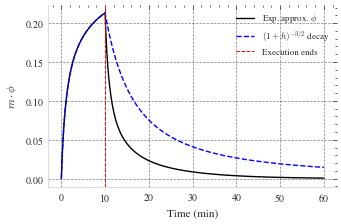

Peak bias: 0.213232


In [27]:
execution_duration = 10 * 60
total_duration = 60 * 60
m = 0.025

kappas = np.log(2) / half_lives
trade_size = 2
total_volume = 100
total_trades = total_volume // trade_size
trade_rate = total_trades / execution_duration
impact_per_trade = np.sqrt(trade_size)

t = np.arange(0, total_duration + 1, 1)
T = execution_duration

# --- Exponential approximation of phi ---
phi = np.zeros_like(t, dtype=float)
for w_k, kappa_k in zip(weights, kappas):
    phi_k = np.where(
        t <= T,
        w_k * (trade_rate * impact_per_trade / kappa_k) * (1 - np.exp(-kappa_k * t)),
        w_k
        * (trade_rate * impact_per_trade / kappa_k)
        * (1 - np.exp(-kappa_k * T))
        * np.exp(-kappa_k * (t - T)),
    )
    phi += phi_k
bias = m * phi

# --- Target phi: plateau approach during exec, h^{-3/2} decay after ---
peak = bias[t <= T][-1]
h = np.clip((t - T) / T, 1e-10, None)  # avoid division by zero
target = np.where(
    t <= T,
    bias,  # same rise (or use ideal shape below)
    peak * (1 + h) ** (-1.5),  # h^{-3/2} decay
)

fig, ax = plt.subplots(figsize=(3.375, 2.2))
ax.plot(t / 60, bias, color="black", lw=1, label=r"Exp. approx. $\phi$")
ax.plot(t / 60, target, color="blue", lw=1, ls="--", label=r"$(1+h)^{-3/2}$ decay")
ax.axvline(x=T / 60, color="r", linestyle="--", lw=0.7, label="Execution ends")
ax.set_xlabel("Time (min)", fontsize=8)
ax.set_ylabel(r"$m \cdot \phi$", fontsize=8)
ax.tick_params(labelsize=7)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(fontsize=6.5, frameon=False)
fig.tight_layout(pad=0.2)
plt.show()

print(f"Peak bias: {bias.max():.6f}")

In [206]:
ticker = "PFE"
df_no_impact = pl.read_csv(
    f"/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/{ticker}/metaorder/59e773d1_pct_100.csv",
    infer_schema_length=10000,
)
df_impact = pl.read_csv(
    f"/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/{ticker}/metaorder/88848186_pct_100.csv",
    infer_schema_length=10000,
)


df_impact = df_impact.with_columns(
    pl.col("avg_mid_price_change") / df_impact["avg_mid_price_change"].max(),
    pl.col("mid_price_change_se") / df_impact["avg_mid_price_change"].max(),
)
df_no_impact = df_no_impact.with_columns(
    pl.col("avg_mid_price_change") / df_no_impact["avg_mid_price_change"].max(),
    pl.col("mid_price_change_se") / df_impact["avg_mid_price_change"].max(),
)

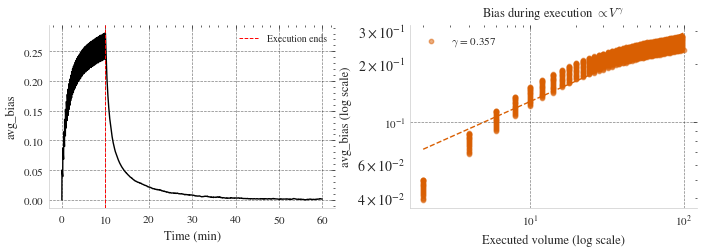

In [207]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5))

# Left: raw bias over time
axes[0].plot(
    np.array(df_impact["timestamp"]) / (int(1e9) * 60),
    np.array(df_impact["avg_bias"]),
    color="black",
    lw=1,
)
axes[0].axvline(x=10, color="r", ls="--", lw=0.7, label="Execution ends")
axes[0].set_xlabel("Time (min)", fontsize=9)
axes[0].set_ylabel("avg_bias", fontsize=9)
axes[0].tick_params(labelsize=8)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].legend(fontsize=7, frameon=False)

# Right: log-log bias vs executed volume (during execution, impact only)
ax = axes[1]
warmup_ns = int(1e9) * 60 * 10
exec_df = df_impact.filter(pl.col("timestamp").le(warmup_ns))

vol = exec_df["avg_meta_vol"].to_numpy()
bias = exec_df["avg_bias"].to_numpy()

pos_mask = (vol > 0) & (bias > 0)
vol_pos = vol[pos_mask]
bias_pos = bias[pos_mask]

log_vol = np.log(vol_pos)
log_bias = np.log(bias_pos)

A = np.vstack([log_vol, np.ones(len(log_vol))]).T
delta, c = np.linalg.lstsq(A, log_bias, rcond=None)[0]

vol_fit = np.linspace(vol_pos.min(), vol_pos.max(), 100)
bias_fit = np.exp(c) * vol_fit**delta

ax.scatter(
    vol_pos,
    bias_pos,
    alpha=0.5,
    s=10,
    color="#D95F02",
    label=rf"$\gamma$ = {delta:.3f}",
)
ax.plot(vol_fit, bias_fit, "--", linewidth=1, color="#D95F02")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Executed volume (log scale)", fontsize=9)
ax.set_ylabel("avg_bias (log scale)", fontsize=9)
ax.tick_params(labelsize=8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(fontsize=8, frameon=False)
ax.set_title(r"Bias during execution $\propto V^\gamma$", fontsize=9)

fig.tight_layout(pad=0.3)
plt.show()

/tmp/ipykernel_2376462/824863865.py:40: RuntimeWarning: invalid value encountered in sqrt
  peak_val * (np.sqrt(1 + h) - np.sqrt(h)),  # sqrt decay


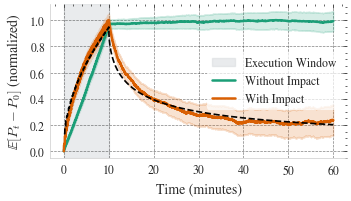

In [211]:
fig, ax = plt.subplots(figsize=(3.5, 2))

x = np.array(df_impact["timestamp"]) / (int(1e9) * 60)
T = 10.0

y_no = np.array(df_no_impact["avg_mid_price_change"])
se_no = np.array(df_no_impact["mid_price_change_se"])
y_im = np.array(df_impact["avg_mid_price_change"])
se_im = np.array(df_impact["mid_price_change_se"])

# execution window
ax.axvspan(0, T, color="#D5D8DC", alpha=0.5, label="Execution Window", zorder=0)

# no-impact series
ax.fill_between(
    x, y_no - 1.96 * se_no, y_no + 1.96 * se_no, alpha=0.18, color="#1B9E77"
)
ax.plot(x, y_no, linewidth=1.8, color="#1B9E77", label="Without Impact")

# impact series
ax.fill_between(
    x, y_im - 1.96 * se_im, y_im + 1.96 * se_im, alpha=0.18, color="#D95F02"
)
ax.plot(x, y_im, linewidth=1.8, color="#D95F02", label="With Impact")

# sqrt(Q) during execution + sqrt(1+h)-sqrt(h) decay after
peak_idx = np.argmin(np.abs(x - T))
peak_val = y_im[peak_idx]

meta_vol = np.array(df_no_impact["avg_meta_vol"])
meta_vol_at_peak = meta_vol[peak_idx]

sqrt_vol = np.sqrt(meta_vol)
sqrt_vol_at_peak = np.sqrt(meta_vol_at_peak)

h = (x - T) / T
sqrt_curve = np.where(
    x <= T,
    peak_val * sqrt_vol / sqrt_vol_at_peak,  # sqrt(Q) rise
    peak_val * (np.sqrt(1 + h) - np.sqrt(h)),  # sqrt decay
)
ax.plot(
    x,
    sqrt_curve,
    linewidth=1.2,
    color="black",
    ls="--",
)

ax.set_xlabel("Time (minutes)", fontsize=10)
ax.set_ylabel(r"$\mathbb{E}[P_t - P_0]$ (normalized)", fontsize=10)
ax.tick_params(labelsize=8.5)
ax.legend(fontsize=8.5, framealpha=0.7, edgecolor="none", loc="best")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout(pad=0.3)
# fig.savefig("../paper/impact_PFE.pdf", bbox_inches="tight")
plt.show()

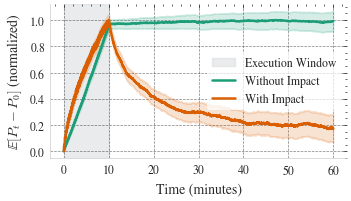

In [41]:
fig, ax = plt.subplots(figsize=(3.5, 2))

x = df_impact["timestamp"] / (int(1e9) * 60)

# execution window
ax.axvspan(0, 10, color="#D5D8DC", alpha=0.5, label="Execution Window", zorder=0)

# no-impact series
y_no = df_no_impact["avg_mid_price_change"]
se_no = df_no_impact["mid_price_change_se"]
ax.fill_between(
    x, y_no - 1.96 * se_no, y_no + 1.96 * se_no, alpha=0.18, color="#1B9E77"
)
ax.plot(x, y_no, linewidth=1.8, color="#1B9E77", label="Without Impact")

# impact series
y_im = df_impact["avg_mid_price_change"]
se_im = df_impact["mid_price_change_se"]
ax.fill_between(
    x, y_im - 1.96 * se_im, y_im + 1.96 * se_im, alpha=0.18, color="#D95F02"
)
ax.plot(x, y_im, linewidth=1.8, color="#D95F02", label="With Impact")

ax.set_xlabel("Time (minutes)", fontsize=10)
ax.set_ylabel(r"$\mathbb{E}[P_t - P_0]$ (normalized)", fontsize=10)
ax.tick_params(labelsize=8.5)

ax.legend(fontsize=8.5, framealpha=0.7, edgecolor="none", loc="best")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.tight_layout(pad=0.3)
plt.show()

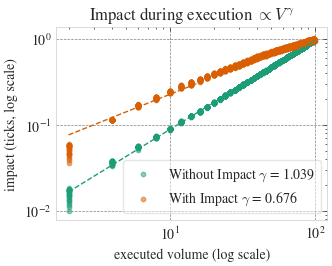

In [212]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

warmup_ns = int(1e9) * 60 * 10
exec_df_no_impact = df_no_impact.filter(pl.col("timestamp").le(warmup_ns))
exec_df_impact = df_impact.filter(pl.col("timestamp").le(warmup_ns))

t_exec_no_impact = exec_df_no_impact["avg_meta_vol"].to_numpy()
impact_exec_no_impact = exec_df_no_impact["avg_mid_price_change"].to_numpy()

# Filter positive values for log-log

pos_mask_no_impact = (t_exec_no_impact > 0) & (impact_exec_no_impact > 0)
t_pos_no_impact = t_exec_no_impact[pos_mask_no_impact]
impact_pos_no_impact = impact_exec_no_impact[pos_mask_no_impact]

log_t_no_impact = np.log(t_pos_no_impact)
log_impact_no_impact = np.log(impact_pos_no_impact)

A = np.vstack([log_t_no_impact, np.ones(len(log_t_no_impact))]).T
delta, c = np.linalg.lstsq(A, log_impact_no_impact, rcond=None)[0]

t_fit_no_impact = np.linspace(t_pos_no_impact.min(), t_pos_no_impact.max(), 100)
impact_fit_no_impact = np.exp(c) * t_fit_no_impact**delta

ax.scatter(
    t_pos_no_impact,
    impact_pos_no_impact,
    alpha=0.5,
    s=10,
    label=rf"Without Impact $\gamma$ = {delta:.3f}",
    color="#1B9E77",
)
ax.plot(t_fit_no_impact, impact_fit_no_impact, "--", linewidth=1, color="#1B9E77")

t_exec_impact = exec_df_impact["avg_meta_vol"].to_numpy()
impact_exec_impact = exec_df_impact["avg_mid_price_change"].to_numpy()

# Filter positive values for log-log
pos_mask_impact = (t_exec_impact > 0) & (impact_exec_impact > 0)
t_pos_impact = t_exec_impact[pos_mask_impact]
impact_pos_impact = impact_exec_impact[pos_mask_impact]

log_t_impact = np.log(t_pos_impact)
log_impact_impact = np.log(impact_pos_impact)

A = np.vstack([log_t_impact, np.ones(len(log_t_impact))]).T
delta, c = np.linalg.lstsq(A, log_impact_impact, rcond=None)[0]

t_fit_impact = np.linspace(t_pos_impact.min(), t_pos_impact.max(), 100)
impact_fit_impact = np.exp(c) * t_fit_impact**delta

ax.scatter(
    t_pos_impact,
    impact_pos_impact,
    alpha=0.5,
    s=10,
    label=rf"With Impact $\gamma$ = {delta:.3f}",
    color="#D95F02",
)
ax.plot(t_fit_impact, impact_fit_impact, "--", linewidth=1, color="#D95F02")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("executed volume (log scale)")
ax.set_ylabel("impact (ticks, log scale)")
ax.legend(framealpha=0.5)
ax.set_title(r"Impact during execution $\propto V^\gamma$")
# fig.savefig("../paper/impact_slope_PFE.pdf", bbox_inches="tight")

plt.show()

## $\Delta t$ GMM Fit

In [49]:
df_sim = pl.read_parquet(
    "/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/PFE/samples/960606ee.parquet"
)
df_sim = preprocess_sim(df_sim)

In [50]:
delta_t = est.group_delta_t(df.lazy())

max_k = 8
global_bic = {k: 0.0 for k in range(1, max_k + 1)}

rows = list(delta_t.iter_rows(named=True))
for row in tqdm(rows, desc="Fitting GMMs"):
    x = np.log10(np.array(row["delta_t"], dtype=float)).reshape(-1, 1)
    if len(x) > 10000:
        x = np.random.default_rng(0).choice(x, 10000, replace=False)
    for k in range(1, max_k + 1):
        gmm = GaussianMixture(n_components=k, random_state=0).fit(x)
        global_bic[k] += gmm.bic(x)

Fitting GMMs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [03:05<00:00,  1.40s/it]


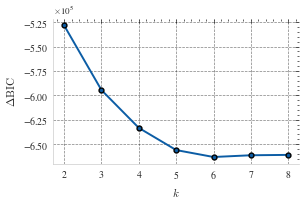

In [51]:
bics = [global_bic[k] for k in range(1, max_k + 1)]
deltas = [bics[k] - bics[0] for k in range(1, len(bics))]

fig, ax = plt.subplots(figsize=(3, 2))

ax.plot(
    range(2, max_k + 1),
    deltas,
    marker="o",
    ms=3.5,
    mec="k",
    lw=1.4,
)

ax.set_xlabel(r"$k$", fontsize=8)
ax.set_ylabel(r"$\Delta\mathrm{BIC}$", fontsize=8)
ax.tick_params(labelsize=7)
ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
ax.yaxis.get_offset_text().set_fontsize(6.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.tight_layout(pad=0.2)
# fig.savefig("../paper/bic_PFE.pdf", bbox_inches="tight")
plt.show()

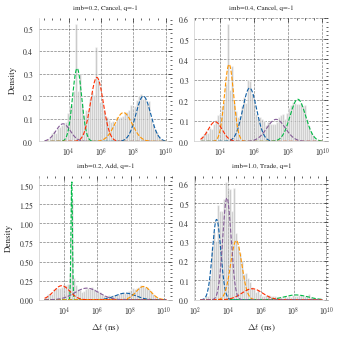

In [52]:
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

row_list = list(delta_t.iter_rows(named=True))

trade_rows = [r for r in row_list if r["event"] == "Trade"]
trade_rows.sort(key=lambda r: len(r["delta_t"]), reverse=True)
best_trade = trade_rows[0]

non_trade = [r for r in row_list if r["event"] != "Trade"]
non_trade.sort(key=lambda r: len(r["delta_t"]), reverse=True)

top_rows = non_trade[:3] + [best_trade]

fig, axes = plt.subplots(2, 2, figsize=(3.375, 3.375))

for ax, row in zip(axes.flat, top_rows):
    x = np.log10(np.array(row["delta_t"], dtype=float)).reshape(-1, 1)
    if len(x) > 10000:
        x = np.random.default_rng(0).choice(x, 10000, replace=False)

    gmm = GaussianMixture(n_components=5, random_state=0).fit(x)

    ax.hist(x, bins=60, density=True, alpha=0.5, color="grey")

    x_grid = np.linspace(x.min(), x.max(), 300)
    for i in range(gmm.n_components):
        y = gmm.weights_[i] * norm.pdf(
            x_grid, gmm.means_[i, 0], np.sqrt(gmm.covariances_[i, 0, 0])
        )
        ax.plot(x_grid, y, "--", lw=0.8)

    # total mixture
    log_prob = gmm.score_samples(x_grid.reshape(-1, 1))

    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"$10^{{{int(v)}}}$"))
    ax.tick_params(labelsize=5.5)
    ax.set_title(
        f"imb={row['imbalance']}, {row['event']}, q={row['queue']}",
        fontsize=5,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[1, 0].set_xlabel(r"$\Delta t$ (ns)", fontsize=6.5)
axes[1, 1].set_xlabel(r"$\Delta t$ (ns)", fontsize=6.5)
axes[0, 0].set_ylabel("Density", fontsize=6.5)
axes[1, 0].set_ylabel("Density", fontsize=6.5)

fig.tight_layout(pad=0.3)
# fig.savefig("../paper/delta_t_gmm_examples_PFE.pdf", bbox_inches="tight", dpi=300)
plt.show()

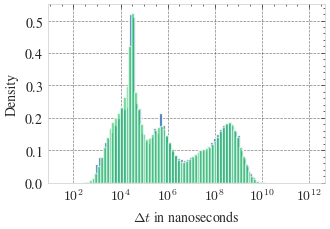

In [53]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))
ax.hist(
    df["delta_t"].explode().log10(),
    bins=80,
    density=True,
    label="Empirical",
    alpha=0.85,
)
ax.hist(
    df_sim.filter(pl.col("dt") > 0)["dt"].log10(),
    bins=80,
    density=True,
    label="QR",
    alpha=0.6,
)
ax.set_xlabel(r"$\Delta t$ in nanoseconds")
ax.set_ylabel("Density")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(x)}}}$"))
fig.tight_layout()
# fig.savefig("../paper/delta_t_gmm_fit_PFE.pdf", bbox_inches="tight")
plt.show()

## Fast events

In [3]:
def plot_zoomed_delta_t(
    df_emp: pl.DataFrame, ticker: str = "PFE", drop: float= 0.5, save: bool = False
) -> tuple[float, float]:
    df_emp = df_emp.drop_nulls()
    df_emp = df_emp.with_columns(dt_log=pl.col("delta_t").log10())
    dt_log = df_emp["dt_log"].to_numpy()

    fig, ax = plt.subplots(figsize=(4, 3))

    counts, edges, patches = ax.hist(dt_log, bins=80, density=True, alpha=0.85)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # find mode and 50% drop level
    mode_idx = np.argmax(counts)
    mode_x = centers[mode_idx]
    mode_y = counts[mode_idx]
    half_y = mode_y * drop

    # find left and right crossings of 50% level
    left_cross = centers[0]
    for i in range(mode_idx, -1, -1):
        if counts[i] < half_y:
            left_cross = centers[i]
            break
    right_cross = centers[-1]
    for i in range(mode_idx, len(counts)):
        if counts[i] < half_y:
            right_cross = centers[i]
            break

    # vertical band for FWHM
    ax.axvspan(left_cross, right_cross, color="#B5121B", alpha=0.15)
    ax.axvline(
        mode_x,
        color="#B5121B",
        ls="--",
        lw=1,
        label=f"Mode $\\approx 10^{{{mode_x:.1f}}}$ ns",
    )

    ax.set_xlabel(r"$\Delta t$ in nanoseconds")
    ax.set_ylabel("Density")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(x)}}}$"))

    # inset zoom on [3, 5], positioned to the right and lower
    axins = ax.inset_axes([0.55, 0.35, 0.42, 0.55])
    axins.hist(dt_log, bins=80, density=True, alpha=0.85)
    axins.axvspan(left_cross, right_cross, color="#B5121B", alpha=0.15)
    axins.axvline(mode_x, color="#B5121B", ls="--", lw=1)
    axins.axhline(half_y, color="grey", ls=":", lw=0.8)

    axins.set_xlim(3, 5)
    axins.set_ylim(0, mode_y * 1.15)
    axins.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(x)}}}$"))
    axins.tick_params(labelsize=5.5)
    axins.set_title(
        f"50% region: [$10^{{{left_cross:.1f}}}$, $10^{{{right_cross:.1f}}}$] ns",
        fontsize=5.5,
    )

    # manual connector lines from bottom corners of inset to the zoom region
    for x_data in [3, 5]:
        con = ConnectionPatch(
            xyA=(x_data, 0),
            coordsA=axins.transData,
            xyB=(x_data, 0),
            coordsB=ax.transData,
            color="gray",
            lw=0.5,
            ls="--",
        )
        fig.add_artist(con)

    # hide the default indicate_inset_zoom box
    axins.set_zorder(10)

    ax.legend(fontsize=6.5, framealpha=0.7, edgecolor="none", loc="upper left")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.tight_layout()
    if save:
        fig.savefig(f"../paper/delta_t_zoomed_peak_{ticker}.pdf", bbox_inches="tight")
    plt.show()
    return left_cross, right_cross

In [4]:
def plot_imbalance_fast(
    df_emp: pl.DataFrame,
    left_cross: float,
    right_cross: float,
    ticker: str = "PFE",
    save: bool = False,
) -> None:
    df_emp = df_emp.drop_nulls()
    df_emp = df_emp.with_columns(dt_log=pl.col("delta_t").log10())
    df_emp = df_emp.with_columns(fast_event=pl.col("dt_log").le(right_cross))
    df_emp = df_emp.with_columns(
        delta_event=pl.col("dt_log").is_between(left_cross, right_cross)
    )

    imb_dist = (
        df_emp.filter(~pl.col("fast_event") & pl.col("event").eq("Trade"))["imbalance"]
        .value_counts(normalize=True)
        .sort("imbalance")
    )

    imb_sim = (
        df_emp.filter(pl.col("delta_event") & pl.col("event").eq("Trade"))["imbalance"]
        .value_counts(normalize=True)
        .sort("imbalance")
    )

    fig, ax = plt.subplots(figsize=(3.5, 2.5))

    x = imb_dist["imbalance"]
    width = 0.05

    ax.bar(x, imb_dist["proportion"], width, label="Control", alpha=0.85)
    ax.bar(x + width * 3.5 / 4, imb_sim["proportion"], width, label="Fast", alpha=0.85)

    ax.set_xlabel("Imbalance Bin")
    ax.set_ylabel("Proportion")
    ax.legend()
    # ax.set_title(f"Binned imbalance distribution (before a trade) Ticker: {ticker}")
    plt.tight_layout()
    fig.savefig(
        f"../paper/imb_distrib_before_trade_fast_events_{ticker}.pdf",
        bbox_inches="tight",
    )
    plt.show()

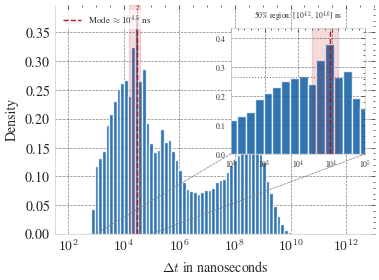

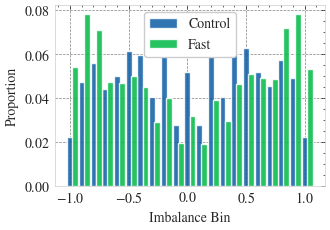

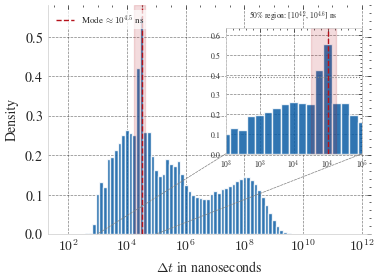

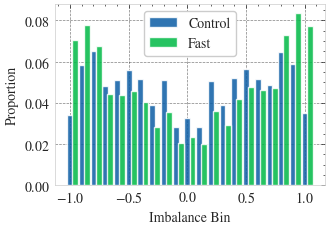

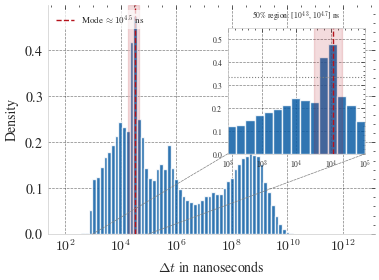

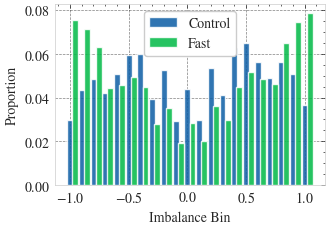

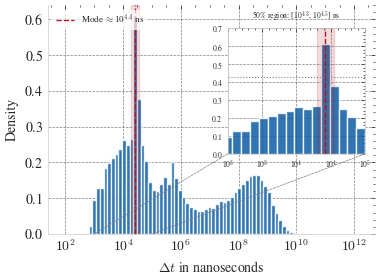

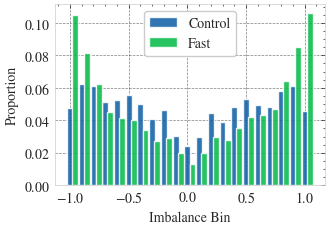

In [5]:
# for ticker in ["VZ", "INTC", "T", "PFE"]:
#     df_, df_emp_ = load_data(ticker)
#     del df_
#     plot_imbalance_fast(
#         df_emp_, *plot_zoomed_delta_t(df_emp_, ticker, drop=0.7, save=True), ticker, True
#     )
#     del df_emp_
#     plt.close("all")
#     gc.collect()

## Alpha

In [131]:
ticker = "PFE"
alpha_pnl_no_impact = pl.read_csv(
    f"/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/{ticker}/samples/0963e4b27cd5bd81_alpha_pnl.csv"
)
alpha_pnl_impact = pl.read_csv(
    f"/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/{ticker}/samples/532bb8b233ec4a1d_alpha_pnl.csv"
)

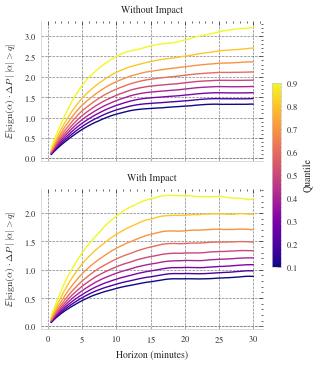

In [204]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.5, 4), sharex=True)

thresholds = sorted(alpha_pnl_no_impact["quantile"].unique().to_list())
norm = mcolors.Normalize(vmin=min(thresholds), vmax=max(thresholds))
cmap = cm.plasma

for thr in thresholds:
    color = cmap(norm(thr))
    sub_no = alpha_pnl_no_impact.filter(pl.col("quantile").eq(thr))
    sub_im = alpha_pnl_impact.filter(pl.col("quantile").eq(thr))

    ax1.plot(sub_no["lag_sec"] / 60, sub_no["alpha_tickreturn_cov"], color=color, lw=1)
    ax2.plot(sub_im["lag_sec"] / 60, sub_im["alpha_tickreturn_cov"], color=color, lw=1)

for ax, title in [(ax1, "Without Impact"), (ax2, "With Impact")]:
    ax.axhline(0, color="grey", lw=0.5, ls="--")
    ax.set_title(title, fontsize=7)
    ax.tick_params(labelsize=6)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

ax2.set_xlabel("Horizon (minutes)", fontsize=7)
ax1.set_ylabel(
    r"$\mathbb{E}[\mathrm{sign}(\alpha) \cdot \Delta P \mid |\alpha| > q]$", fontsize=7
)
ax2.set_ylabel(
    r"$\mathbb{E}[\mathrm{sign}(\alpha) \cdot \Delta P \mid |\alpha| > q]$", fontsize=7
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, pad=0.03)
cbar.set_label("Quantile", fontsize=7)
cbar.ax.tick_params(labelsize=6)

# fig.tight_layout(pad=0.3)
fig.savefig("../paper/alpha_deltaP_PFE.pdf", bbox_inches="tight")
plt.show()

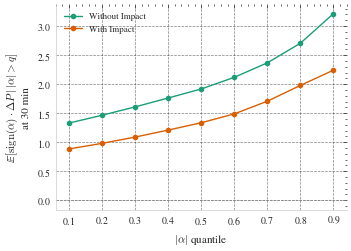

In [203]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

max_lag = alpha_pnl_no_impact["lag_sec"].max()

term_no = alpha_pnl_no_impact.filter(pl.col("lag_sec") == max_lag).sort("quantile")
term_im = alpha_pnl_impact.filter(pl.col("lag_sec") == max_lag).sort("quantile")

ax.plot(
    term_no["quantile"],
    term_no["alpha_tickreturn_cov"],
    lw=1,
    marker="o",
    markersize=3,
    color="#1B9E77",
    label="Without Impact",
)
ax.plot(
    term_im["quantile"],
    term_im["alpha_tickreturn_cov"],
    lw=1,
    marker="o",
    markersize=3,
    color="#D95F02",
    label="With Impact",
)

ax.axhline(0, color="grey", lw=0.5, ls="--")
ax.set_xlabel(r"$|\alpha|$ quantile", fontsize=8)
ax.set_ylabel(
    r"$\mathbb{E}[\mathrm{sign}(\alpha) \cdot \Delta P \mid |\alpha| > q]$"
    f"\nat {max_lag/60:.0f} min",
    fontsize=8,
)
ax.tick_params(labelsize=7)
ax.legend(fontsize=6.5, frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.tight_layout(pad=0.3)
fig.savefig("../paper/terminal_impact_PFE.pdf", bbox_inches="tight")
plt.show()

In [29]:
def unconditional_predictiveness(
    df: pl.DataFrame,
    horizons: list[int] = list(range(1, 61)),
    resample_ms: int = 500,
) -> pl.DataFrame:
    resample_ns = resample_ms * 1_000_000

    df_rs = (
        df.select("ts_event", "mid", "imbalance", "alpha")
        .with_columns((pl.col("ts_event") // resample_ns).alias("ts_bin"))
        .group_by("ts_bin")
        .agg(pl.col("mid").last(), pl.col("imbalance").last(), pl.col("alpha").last())
        .sort("ts_bin")
    )

    mid = df_rs["mid"]
    rows = []

    for h in horizons:
        fwd = mid.shift(-h)
        dp = fwd - mid

        for sig in ["imbalance", "alpha"]:
            product = df_rs[sig] * dp
            vals = product.drop_nulls()
            n = len(vals)
            if n == 0:
                continue
            rows.append(
                (sig, h * resample_ms / 1000, vals.mean(), vals.std() / n**0.5, n)
            )

    return pl.DataFrame(
        rows,
        schema={
            "signal": pl.Utf8,
            "horizon_s": pl.Float64,
            "mean": pl.Float64,
            "se": pl.Float64,
            "n": pl.UInt32,
        },
        orient="row",
    )


def imbalance_predictiveness(
    df: pl.DataFrame,
    horizons: list[int] = list(range(1, 61)),
    thresholds: list[float] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    resample_ms: int = 500,
) -> pl.DataFrame:
    """
    Compute E[sign(Imb) * (P_{t+h} - P_t) | |Imb| > threshold]

    Args:
      df: parquet with ts_event (ns), mid, imb
      horizons: list of horizon steps (in units of resample_ms)
      thresholds: |imb| thresholds to condition on
      resample_ms: resampling interval in milliseconds

    Returns:
      DataFrame with columns: threshold, horizon_s, mean, se, count
    """
    df = df.filter(~pl.col("rejected"))
    resample_ns = resample_ms * 1_000_000

    # resample to regular grid
    df_rs = (
        df.select("ts_event", "mid", "imbalance")
        .with_columns((pl.col("ts_event") // resample_ns).alias("ts_bin"))
        .group_by("ts_bin")
        .agg(pl.col("mid").last(), pl.col("imbalance").last())
        .sort("ts_bin")
    )

    # precompute sign and abs
    imb_sign = df_rs["imbalance"].sign()
    imb_abs = df_rs["imbalance"].abs()
    mid = df_rs["mid"]

    rows = []
    for thr in thresholds:
        mask = imb_abs > thr
        for h in horizons:
            sym_dp = (imb_sign * (mid.shift(-h) - mid)).filter(mask).drop_nulls()
            n = len(sym_dp)
            if n == 0:
                continue
            m = sym_dp.mean()
            s = sym_dp.std() / (n**0.5)
            rows.append((thr, h * resample_ms / 1000, m, s, n))

    return pl.DataFrame(
        rows,
        schema={
            "threshold": pl.Float64,
            "horizon_s": pl.Float64,
            "mean": pl.Float64,
            "se": pl.Float64,
            "count": pl.Int64,
        },
        orient="row",
    )


def signal_predictiveness(
    df: pl.DataFrame,
    horizons: list[int] = list(range(1, 61)),
    thresholds: list[float] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    resample_ms: int = 500,
) -> pl.DataFrame:
    resample_ns = resample_ms * 1_000_000
    df = df.filter(~pl.col("rejected"))
    df_rs = (
        df.select("ts_event", "mid", "imbalance", "alpha")
        .with_columns((pl.col("ts_event") // resample_ns).alias("ts_bin"))
        .group_by("ts_bin")
        .agg(pl.col("mid").last(), pl.col("imbalance").last(), pl.col("alpha").last())
        .sort("ts_bin")
    )

    mid = df_rs["mid"]
    rows = []

    for h in horizons:
        fwd = mid.shift(-h)

        for thr in thresholds:
            row = {"threshold": thr, "horizon_s": h * resample_ms / 1000}

            for sig in ["imbalance", "alpha"]:
                sig_sign = df_rs[sig].sign()
                sig_abs = df_rs[sig].abs()
                dp = sig_sign * (fwd - mid)
                vals = dp.filter(sig_abs > thr).drop_nulls()
                n = len(vals)
                if n == 0:
                    row[f"{sig}_mean"] = None
                    row[f"{sig}_se"] = None
                    row[f"{sig}_n"] = None
                else:
                    row[f"{sig}_mean"] = vals.mean()
                    row[f"{sig}_se"] = vals.std() / n**0.5
                    row[f"{sig}_n"] = n

            rows.append(row)

    return pl.DataFrame(rows)


def preprocess_race_sim(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns((pl.col("ts_event") // DAY_NS).alias("date"))
    # df = df.filter(~pl.col("rejected"))
    df = df.filter(~(pl.col("event").eq("Add") & pl.col("partial")))
    df = df.with_columns(pl.col("ts_event").diff().alias("dt"))
    # condlist = [
    #     *[
    #         pl.col("imbalance").ge(left) & pl.col("imbalance").lt(right)
    #         for left, right in zip(-est.BINS[1:][::-1], -est.BINS[:-1][::-1])
    #     ],
    #     pl.col("imbalance").eq(0),
    #     *[
    #         pl.col("imbalance").gt(left) & pl.col("imbalance").le(right)
    #         for left, right in zip(est.BINS[:-1], est.BINS[1:])
    #     ],
    # ]
    # choicelist = [*(-est.BINS[1:][::-1]), 0, *est.BINS[1:]]
    # df = df.with_columns(imbalance=pl_select(condlist, choicelist))
    return df.drop_nulls()

In [30]:
df_no_impact = pl.read_parquet(
    "/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/PFE/samples/422ab5ed1669cd76.parquet"
)
df_no_impact = preprocess_race_sim(df_no_impact)
df_impact = pl.read_parquet(
    "/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/PFE/samples/3a5b392cd3f77001.parquet"
)
df_impact = preprocess_race_sim(df_impact)

In [31]:
result_no_impact = imbalance_predictiveness(df_no_impact)
result_impact = imbalance_predictiveness(df_impact)

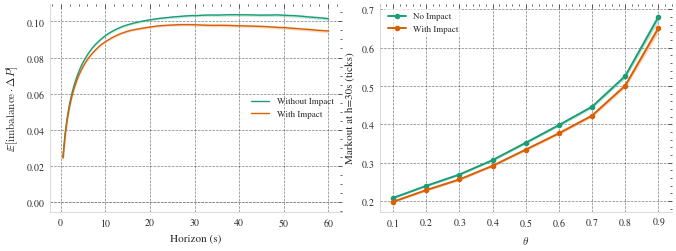

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(6.75, 2.5))

# Left: unconditional imbalance predictiveness impact vs no impact
ax = axes[0]
for df, color, label in [
    (df_no_impact, "#1B9E77", "Without Impact"),
    (df_impact, "#D95F02", "With Impact"),
]:
    res = unconditional_predictiveness(df, horizons=list(range(1, 121)))
    sub = res.filter(pl.col("signal") == "imbalance").sort("horizon_s")
    h = sub["horizon_s"].to_numpy()
    m = sub["mean"].to_numpy()
    se = sub["se"].to_numpy()
    ax.plot(h, m, color=color, lw=1, label=label)
    ax.fill_between(h, m - 2 * se, m + 2 * se, color=color, alpha=0.15)
ax.axhline(0, color="grey", lw=0.5, ls="--")
ax.set_xlabel("Horizon (s)", fontsize=8)
ax.set_ylabel(r"$\mathbb{E}[\mathrm{imbalance} \cdot \Delta P]$", fontsize=8)
ax.tick_params(labelsize=7)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(fontsize=6.5, frameon=False)

# Right: markout at max horizon vs threshold
ax = axes[1]
max_h = int(max(result_no_impact["horizon_s"]))
for result, label, color in [
    (result_no_impact, "No Impact", "#1B9E77"),
    (result_impact, "With Impact", "#D95F02"),
]:
    thresholds = sorted(result["threshold"].unique().to_list())
    means = []
    ses = []
    for thr in thresholds:
        sub = result.filter(
            (pl.col("threshold") == thr) & (pl.col("horizon_s") == max_h)
        )
        means.append(sub["mean"][0])
        ses.append(sub["se"][0])
    means, ses = np.array(means), np.array(ses)
    ax.plot(
        thresholds, means, marker="o", markersize=3, color=color, lw=1.4, label=label
    )
    ax.fill_between(
        thresholds, means - 1.96 * ses, means + 1.96 * ses, color=color, alpha=0.18
    )
ax.set_xlabel(r"$\theta$", fontsize=8)
ax.set_ylabel(f"Markout at h={max_h}s (ticks)", fontsize=8)
ax.tick_params(labelsize=7)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(fontsize=6.5, framealpha=0.7, edgecolor="none")

fig.tight_layout(pad=0.3)
plt.show()

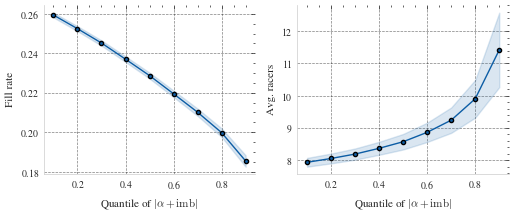

In [15]:
df2 = df_impact.with_columns(
    (pl.col("source").diff().fill_null(1) != 0).cum_sum().alias("race_id")
)

race_stats = (
    df2.filter((pl.col("source") == 1) & (pl.col("event") == "Trade"))
    .group_by("race_id")
    .agg(
        pl.col("alpha").first(),
        pl.col("imbalance").first(),
        pl.col("filled_size").sum().alias("total_filled"),
        pl.col("size").sum().alias("total_size"),
        pl.col("size").count().alias("num_racers"),
    )
    .with_columns(
        (pl.col("total_filled") / pl.col("total_size")).alias("fill_rate"),
        (pl.col("alpha") + pl.col("imbalance")).abs().alias("abs_signal"),
    )
)

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
thresholds = [race_stats["abs_signal"].quantile(q) for q in quantiles]

rows = []
for q, thr in zip(quantiles, thresholds):
    sub = race_stats.filter(pl.col("abs_signal") > thr)
    n = len(sub)
    if n == 0:
        continue
    rows.append(
        (
            q,
            thr,
            sub["fill_rate"].mean(),
            sub["fill_rate"].std() / n**0.5,
            sub["num_racers"].mean(),
            sub["num_racers"].std() / n**0.5,
            n,
        )
    )

binned = pl.DataFrame(
    rows,
    schema={
        "quantile": pl.Float64,
        "threshold": pl.Float64,
        "fill_rate": pl.Float64,
        "fr_se": pl.Float64,
        "num_racers": pl.Float64,
        "nr_se": pl.Float64,
        "n": pl.UInt32,
    },
    orient="row",
)

x = binned["quantile"].to_numpy()

style = dict(color="C0", lw=1, marker="o", mec="k", ms=3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3 * 2, 2.2))

y1 = binned["fill_rate"].to_numpy()
se1 = binned["fr_se"].to_numpy()
ax1.plot(x, y1, **style)
ax1.fill_between(x, y1 - 2 * se1, y1 + 2 * se1, color="C0", alpha=0.15)
ax1.set_xlabel(r"Quantile of $|\alpha + \mathrm{imb}|$", fontsize=8)
ax1.set_ylabel("Fill rate", fontsize=8)

y2 = binned["num_racers"].to_numpy()
se2 = binned["nr_se"].to_numpy()
ax2.plot(x, y2, **style)
ax2.fill_between(x, y2 - 2 * se2, y2 + 2 * se2, color="C0", alpha=0.15)
ax2.set_xlabel(r"Quantile of $|\alpha + \mathrm{imb}|$", fontsize=8)
ax2.set_ylabel("Avg. racers", fontsize=8)

for ax in (ax1, ax2):
    ax.tick_params(labelsize=7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# fig.tight_layout(pad=0.2)
plt.show()

In [16]:
result_no_impact = signal_predictiveness(df_no_impact)
result_impact = signal_predictiveness(df_impact)

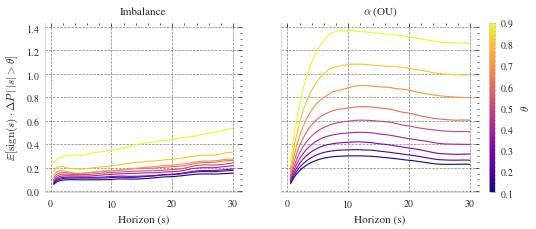

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.375 * 2, 2.2), sharey=True)

thresholds = sorted(result_no_impact["threshold"].unique().to_list())
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=min(thresholds), vmax=max(thresholds))

for ax, sig, title in [
    (ax1, "imbalance", "Imbalance"),
    (ax2, "alpha", r"$\alpha$ (OU)"),
]:
    for thr in thresholds:
        sub = result_no_impact.filter(pl.col("threshold") == thr).sort("horizon_s")
        h = sub["horizon_s"].to_numpy()
        m = sub[f"{sig}_mean"].to_numpy()
        ax.plot(h, m, color=cmap(norm(thr)), lw=0.8)

    ax.set_xlabel("Horizon (s)", fontsize=8)
    ax.set_title(title, fontsize=8)
    ax.tick_params(labelsize=7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

ax1.set_ylabel(
    r"$\mathbb{E}[\mathrm{sign}(s) \cdot \Delta P \mid |s|>\theta]$", fontsize=8
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=[ax1, ax2], pad=0.02, aspect=30)
cbar.set_label(r"$\theta$", fontsize=8)
cbar.ax.tick_params(labelsize=7)

# fig.tight_layout(pad=0.2)
plt.show()

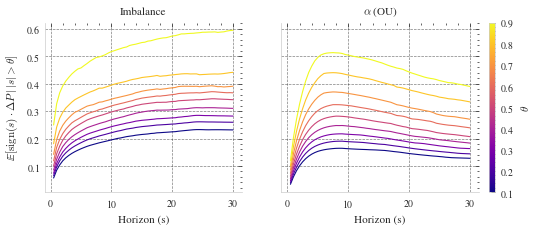

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.375 * 2, 2.2), sharey=True)

thresholds = sorted(result_impact["threshold"].unique().to_list())
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=min(thresholds), vmax=max(thresholds))

for ax, sig, title in [
    (ax1, "imbalance", "Imbalance"),
    (ax2, "alpha", r"$\alpha$ (OU)"),
]:
    for thr in thresholds:
        sub = result_impact.filter(pl.col("threshold") == thr).sort("horizon_s")
        h = sub["horizon_s"].to_numpy()
        m = sub[f"{sig}_mean"].to_numpy()
        ax.plot(h, m, color=cmap(norm(thr)), lw=0.8)

    ax.set_xlabel("Horizon (s)", fontsize=8)
    ax.set_title(title, fontsize=8)
    ax.tick_params(labelsize=7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

ax1.set_ylabel(
    r"$\mathbb{E}[\mathrm{sign}(s) \cdot \Delta P \mid |s|>\theta]$", fontsize=8
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=[ax1, ax2], pad=0.02, aspect=30)
cbar.set_label(r"$\theta$", fontsize=8)
cbar.ax.tick_params(labelsize=7)

# fig.tight_layout(pad=0.2)
plt.show()

In [ ]:
resample_ns = 500 * 1_000_000
alpha_rs = (
    df_no_impact.select("ts_event", "imbalance")
    .with_columns((pl.col("ts_event") // resample_ns).alias("ts_bin"))
    .group_by("ts_bin")
    .agg(pl.col("imbalance").last())
)["imbalance"]

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
q_thresholds = [alpha_rs.abs().quantile(q) for q in quantiles]

result_no_impact = signal_predictiveness(df_no_impact)
result_impact = signal_predictiveness(df_impact)

In [12]:
def alpha_predictiveness_by_std(
    df: pl.DataFrame,
    std_multiples: list[float] = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0],
    horizons: list[int] = list(range(1, 61)),
    resample_ms: int = 500,
) -> pl.DataFrame:
    resample_ns = resample_ms * 1_000_000

    df_rs = (
        df.select("ts_event", "mid", "alpha")
        .with_columns((pl.col("ts_event") // resample_ns).alias("ts_bin"))
        .group_by("ts_bin")
        .agg(pl.col("mid").last(), pl.col("alpha").last())
        .sort("ts_bin")
    )

    alpha = df_rs["alpha"]
    alpha_std = alpha.std()
    mid = df_rs["mid"]
    sig_sign = alpha.sign()
    sig_abs = alpha.abs()

    rows = []
    for h in horizons:
        fwd = mid.shift(-h)
        dp = sig_sign * (fwd - mid)
        for mult in std_multiples:
            thr = mult * alpha_std
            vals = dp.filter(sig_abs > thr).drop_nulls()
            n = len(vals)
            if n == 0:
                continue
            rows.append(
                (mult, thr, h * resample_ms / 1000, vals.mean(), vals.std() / n**0.5, n)
            )

    return pl.DataFrame(
        rows,
        schema={
            "std_mult": pl.Float64,
            "threshold": pl.Float64,
            "horizon_s": pl.Float64,
            "mean_sym_dp": pl.Float64,
            "se": pl.Float64,
            "n": pl.UInt32,
        },
        orient="row",
    )

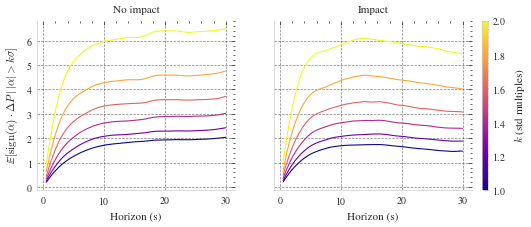

In [31]:
res_no = alpha_predictiveness_by_std(df_no_impact)
res_im = alpha_predictiveness_by_std(df_impact)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.375 * 2, 2.2), sharey=True)

mults = sorted(res_no["std_mult"].unique().to_list())
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=min(mults), vmax=max(mults))

for ax, res, title in [(ax1, res_no, "No impact"), (ax2, res_im, "Impact")]:
    for mult in mults:
        sub = res.filter(pl.col("std_mult") == mult).sort("horizon_s")
        h = sub["horizon_s"].to_numpy()
        m = sub["mean_sym_dp"].to_numpy()
        ax.plot(h, m, color=cmap(norm(mult)), lw=0.8)

    ax.set_xlabel("Horizon (s)", fontsize=8)
    ax.set_title(title, fontsize=8)
    ax.tick_params(labelsize=7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

ax1.set_ylabel(
    r"$\mathbb{E}[\mathrm{sign}(\alpha) \cdot \Delta P \mid |\alpha|>k\sigma]$",
    fontsize=8,
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=[ax1, ax2], pad=0.02, aspect=30)
cbar.set_label(r"$k$ (std multiples)", fontsize=8)
cbar.ax.tick_params(labelsize=7)

# fig.tight_layout(pad=0.2)
plt.show()

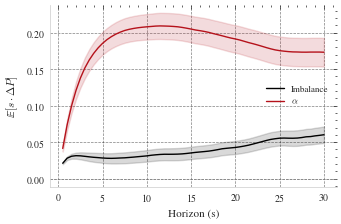

In [21]:
res = unconditional_predictiveness(df_no_impact)

fig, ax = plt.subplots(figsize=(3.375, 2.2))

for sig, color, label in [
    ("imbalance", "black", "Imbalance"),
    ("alpha", "#B5121B", r"$\alpha$"),
]:
    sub = res.filter(pl.col("signal") == sig).sort("horizon_s")
    h = sub["horizon_s"].to_numpy()
    m = sub["mean"].to_numpy()
    se = sub["se"].to_numpy()
    ax.plot(h, m, color=color, lw=1, label=label)
    ax.fill_between(h, m - 2 * se, m + 2 * se, color=color, alpha=0.15)

ax.axhline(0, color="grey", lw=0.5, ls="--")
ax.set_xlabel("Horizon (s)", fontsize=8)
ax.set_ylabel(r"$\mathbb{E}[s \cdot \Delta P]$", fontsize=8)
ax.tick_params(labelsize=7)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(fontsize=6.5, frameon=False)

fig.tight_layout(pad=0.2)
plt.show()

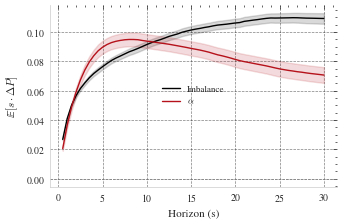

In [22]:
res = unconditional_predictiveness(df_impact)

fig, ax = plt.subplots(figsize=(3.375, 2.2))

for sig, color, label in [
    ("imbalance", "black", "Imbalance"),
    ("alpha", "#B5121B", r"$\alpha$"),
]:
    sub = res.filter(pl.col("signal") == sig).sort("horizon_s")
    h = sub["horizon_s"].to_numpy()
    m = sub["mean"].to_numpy()
    se = sub["se"].to_numpy()
    ax.plot(h, m, color=color, lw=1, label=label)
    ax.fill_between(h, m - 2 * se, m + 2 * se, color=color, alpha=0.15)

ax.axhline(0, color="grey", lw=0.5, ls="--")
ax.set_xlabel("Horizon (s)", fontsize=8)
ax.set_ylabel(r"$\mathbb{E}[s \cdot \Delta P]$", fontsize=8)
ax.tick_params(labelsize=7)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(fontsize=6.5, frameon=False)

fig.tight_layout(pad=0.2)
plt.show()

In [87]:
ticker = "PFE"
pnl_no_impact = pl.read_parquet(
    f"../data/results/{ticker}/strategy/95d98a361d3a2bf8.parquet"
)
pnl_impact = pl.read_parquet(
    f"../data/results/{ticker}/strategy/1608535c8453a59b.parquet"
)

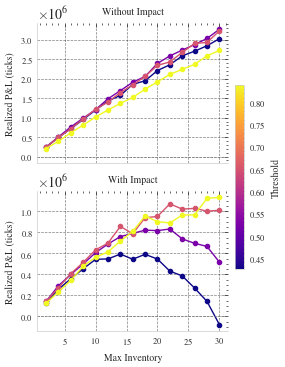

In [92]:
def plot_pnl_comparison(df_no_impact, df_impact, q_max):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 4), sharex=True)

    thresholds = sorted(
        df_no_impact.filter(pl.col("q_max") == q_max)["threshold"].unique().to_list()
    )
    norm = mcolors.Normalize(vmin=min(thresholds), vmax=max(thresholds))
    cmap = cm.plasma

    for ax, df, title in [
        (ax1, df_no_impact, "Without Impact"),
        (ax2, df_impact, "With Impact"),
    ]:
        sub = df.filter(pl.col("q_max") == q_max)
        for thr in thresholds:
            s = sub.filter(pl.col("threshold") == thr).sort("max_inventory")
            ax.plot(
                s["max_inventory"],
                s["realized_pnl"],
                color=cmap(norm(thr)),
                lw=1,
                marker="o",
                markersize=3,
            )
        ax.axhline(0, color="grey", lw=0.5, ls="--")
        ax.set_title(title, fontsize=7)
        ax.tick_params(labelsize=6)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    ax2.set_xlabel("Max Inventory", fontsize=7)
    ax1.set_ylabel("Realized P&L (ticks)", fontsize=7)
    ax2.set_ylabel("Realized P&L (ticks)", fontsize=7)

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, pad=0.03)
    cbar.set_label("Threshold", fontsize=7)
    cbar.ax.tick_params(labelsize=6)

    # fig.tight_layout(pad=0.3)
    # fig.savefig("../paper/pnl_vs_max_inventory_PFE.pdf", bbox_inches="tight")
    plt.show()


plot_pnl_comparison(pnl_no_impact, pnl_impact, q_max=5)

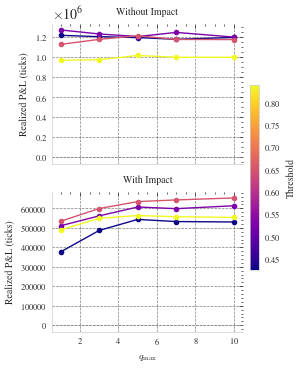

In [90]:
def plot_pnl_vs_qmax(df_no_impact, df_impact, max_inventory):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 4), sharex=True)

    thresholds = sorted(
        df_no_impact.filter(pl.col("max_inventory") == max_inventory)["threshold"]
        .unique()
        .to_list()
    )
    norm = mcolors.Normalize(vmin=min(thresholds), vmax=max(thresholds))
    cmap = cm.plasma

    for ax, df, title in [
        (ax1, df_no_impact, "Without Impact"),
        (ax2, df_impact, "With Impact"),
    ]:
        sub = df.filter(pl.col("max_inventory") == max_inventory)
        for thr in thresholds:
            s = sub.filter(pl.col("threshold") == thr).sort("q_max")
            ax.plot(
                s["q_max"],
                s["realized_pnl"],
                color=cmap(norm(thr)),
                lw=1,
                marker="o",
                markersize=3,
            )
        ax.axhline(0, color="grey", lw=0.5, ls="--")
        ax.set_title(title, fontsize=7)
        ax.tick_params(labelsize=6)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    ax2.set_xlabel(r"$q_{\max}$", fontsize=7)
    ax1.set_ylabel("Realized P&L (ticks)", fontsize=7)
    ax2.set_ylabel("Realized P&L (ticks)", fontsize=7)

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, pad=0.03)
    cbar.set_label("Threshold", fontsize=7)
    cbar.ax.tick_params(labelsize=6)

    # fig.savefig("../paper/pnl_vs_qmax_PFE.pdf", bbox_inches="tight")
    plt.show()


plot_pnl_vs_qmax(pnl_no_impact, pnl_impact, max_inventory=10)

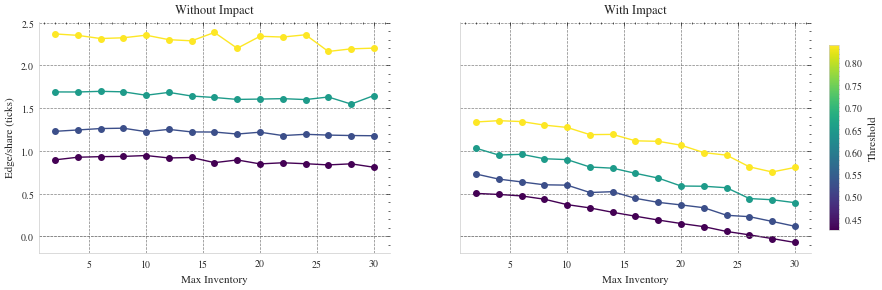

In [186]:
def plot_edge_comparison(df_no_impact, df_impact, q_max):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

    thresholds = sorted(
        df_no_impact.filter(pl.col("q_max") == q_max)["threshold"].unique().to_list()
    )
    norm = mcolors.Normalize(vmin=min(thresholds), vmax=max(thresholds))
    cmap = cm.viridis

    for ax, df, title in [
        (ax1, df_no_impact, "Without Impact"),
        (ax2, df_impact, "With Impact"),
    ]:
        sub = df.filter(pl.col("q_max") == q_max)
        for thr in thresholds:
            s = sub.filter(pl.col("threshold") == thr).sort("max_inventory")
            ax.plot(
                s["max_inventory"],
                s["edge_per_share"],
                color=cmap(norm(thr)),
                lw=1,
                marker="o",
                markersize=4,
                # mec="k"
            )
        ax.axhline(0, color="grey", lw=0.5, ls="--")
        ax.set_xlabel("Max Inventory", fontsize=8)
        ax.set_title(title, fontsize=9)
        ax.tick_params(labelsize=7)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    ax1.set_ylabel("Edge/share (ticks)", fontsize=8)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.8, pad=0.02)
    cbar.set_label("Threshold", fontsize=8)
    cbar.ax.tick_params(labelsize=7)
    fig.savefig("../paper/pnl_per_share_vs_max_inventory_PFE.pdf")
    # fig.tight_layout(pad=0.3)
    plt.show()


plot_edge_comparison(pnl_no_impact, pnl_impact, q_max=3)

In [159]:
def plot_pnl_vs_qmax(edges: pl.DataFrame, max_inv: int):
    sub = edges.filter(pl.col("max_inventory") == max_inv)
    thresholds = sorted(sub["threshold"].unique().to_list())

    cmap = cm.viridis
    norm = plt.Normalize(min(thresholds), max(thresholds))

    fig, ax = plt.subplots(figsize=(5, 3))
    for thr in thresholds:
        curve = sub.filter(pl.col("threshold") == thr).sort("q_max")
        ax.plot(
            curve["q_max"],
            curve["edge_per_share"],
            marker="o",
            markersize=4,
            color=cmap(norm(thr)),
        )

    ax.axhline(0, color="k", linewidth=0.5, linestyle="--")
    ax.set_xlabel("q_max")
    ax.set_ylabel("realized PnL")
    ax.set_title(f"max_inventory = {max_inv}")
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm, ax=ax, label="threshold")
    fig.tight_layout()


def plot_pnl_vs_threshold(edges: pl.DataFrame, max_inv: int):
    sub = edges.filter(pl.col("max_inventory") == max_inv)
    q_maxes = sorted(sub["q_max"].unique().to_list())

    cmap = cm.viridis
    norm = plt.Normalize(min(q_maxes), max(q_maxes))

    fig, ax = plt.subplots(figsize=(5, 3))
    for q in q_maxes:
        curve = sub.filter(pl.col("q_max") == q).sort("threshold")
        ax.plot(
            curve["threshold"],
            curve["edge_per_share"],
            marker="o",
            markersize=4,
            color=cmap(norm(q)),
        )

    ax.axhline(0, color="k", linewidth=0.5, linestyle="--")
    ax.set_xlabel("threshold")
    ax.set_ylabel("realized PnL")
    ax.set_title(f"max_inventory = {max_inv}")
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm, ax=ax, label="q_max")
    fig.tight_layout()


def plot_pnl_vs_max_inv(edges: pl.DataFrame, threshold: float):
    sub = edges.filter(pl.col("threshold") == threshold)
    q_maxes = sorted(sub["q_max"].unique().to_list())

    cmap = cm.viridis
    norm = plt.Normalize(min(q_maxes), max(q_maxes))

    fig, ax = plt.subplots(figsize=(5, 3))
    for q in q_maxes:
        curve = sub.filter(pl.col("q_max") == q).sort("max_inventory")
        ax.plot(
            curve["max_inventory"],
            curve["edge_per_share"],
            marker="o",
            markersize=4,
            color=cmap(norm(q)),
        )

    ax.axhline(0, color="k", linewidth=0.5, linestyle="--")
    ax.set_xlabel("max_inventory")
    ax.set_ylabel("realized PnL")
    ax.set_title(f"threshold = {threshold}")
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm, ax=ax, label="q_max")
    fig.tight_layout()


def plot_round_trips_contour(edges: pl.DataFrame, threshold: float):
    sub = edges.filter(pl.col("threshold") == threshold).sort("q_max", "max_inventory")

    q_maxes = sorted(sub["q_max"].unique().to_list())
    max_invs = sorted(sub["max_inventory"].unique().to_list())

    mat = np.full((len(q_maxes), len(max_invs)), np.nan)
    for row in sub.iter_rows(named=True):
        ri = q_maxes.index(row["q_max"])
        ci = max_invs.index(row["max_inventory"])
        mat[ri, ci] = row["n_round_trips"]

    X, Y = np.meshgrid(max_invs, q_maxes)

    fig, ax = plt.subplots(figsize=(5, 3))
    cs = ax.contourf(X, Y, mat, levels=15, cmap="viridis")
    ax.contour(X, Y, mat, levels=15, colors="k", linewidths=0.3)
    fig.colorbar(cs, ax=ax, label="round trips")
    ax.set_xlabel("max_inventory")
    ax.set_ylabel("q_max")
    ax.set_title(f"Round trips | threshold = {threshold}")
    fig.tight_layout()


def plot_edge_heatmaps(df, q_max: int, cmap="RdYlGn"):
    q_maxes = sorted(df["q_max"].unique().to_list())
    fig, axes = plt.subplots(
        1, len(q_maxes), figsize=(3 * len(q_maxes), 3), sharey=True
    )
    if len(q_maxes) == 1:
        axes = [axes]

    for ax, q in zip(axes, q_maxes):
        sub = df.filter(pl.col("q_max") == q)
        pivot = sub.pivot(
            on="max_inventory", index="threshold", values="edge_per_share"
        ).sort("threshold")
        thresholds = pivot["threshold"].to_numpy()
        inventories = sorted(sub["max_inventory"].unique().to_list())
        Z = pivot.select([str(c) for c in inventories]).to_numpy()

        im = ax.imshow(
            Z,
            aspect="auto",
            origin="lower",
            extent=[inventories[0], inventories[-1], thresholds[0], thresholds[-1]],
            cmap=cmap,
        )
        ax.set_xlabel("Max Inv.", fontsize=7)
        ax.set_title(f"q={q}", fontsize=8)
        ax.tick_params(labelsize=6)

    axes[0].set_ylabel("Threshold", fontsize=8)
    cbar = fig.colorbar(im, ax=list(axes), shrink=0.8, pad=0.02)
    cbar.set_label("Edge/share", fontsize=8)
    cbar.ax.tick_params(labelsize=7)
    fig.tight_layout(pad=0.3)
    plt.show()

In [111]:
pnl_no_impact["threshold"].unique().sort()

threshold
f64
0.0631
0.1267
0.1924
0.2619
0.3382
0.4237
0.5237
0.6501
0.8394


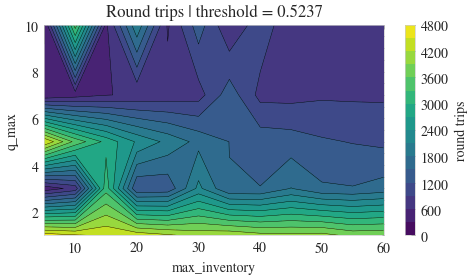

In [116]:
plot_round_trips_contour(pnl_no_impact, threshold=0.5237)

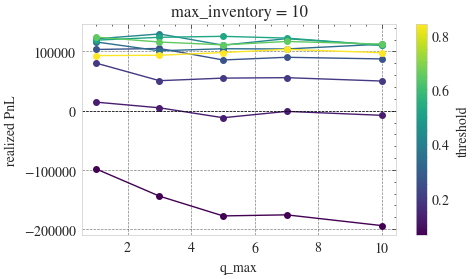

In [157]:
plot_pnl_vs_qmax(pnl_no_impact, max_inv=10)

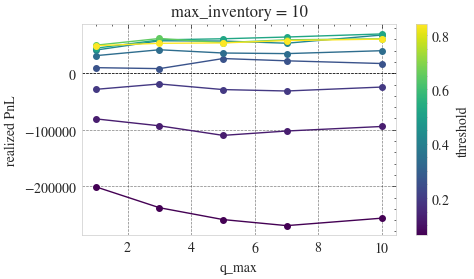

In [158]:
plot_pnl_vs_qmax(pnl_impact, max_inv=10)

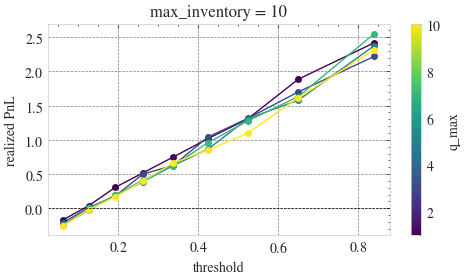

In [121]:
plot_pnl_vs_threshold(pnl_no_impact, max_inv=10)

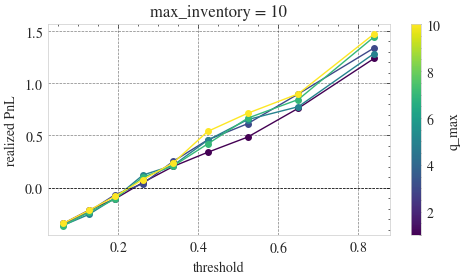

In [122]:
plot_pnl_vs_threshold(pnl_impact, max_inv=10)

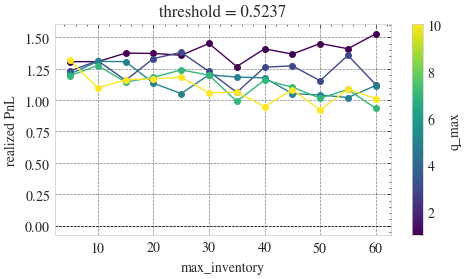

In [123]:
plot_pnl_vs_max_inv(pnl_no_impact, threshold=0.5237)

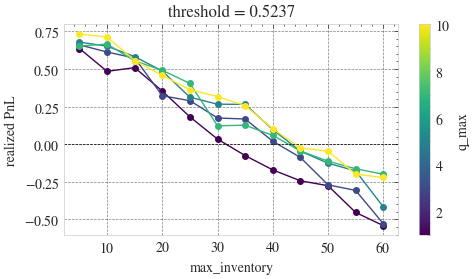

In [124]:
plot_pnl_vs_max_inv(pnl_impact, threshold=0.5237)

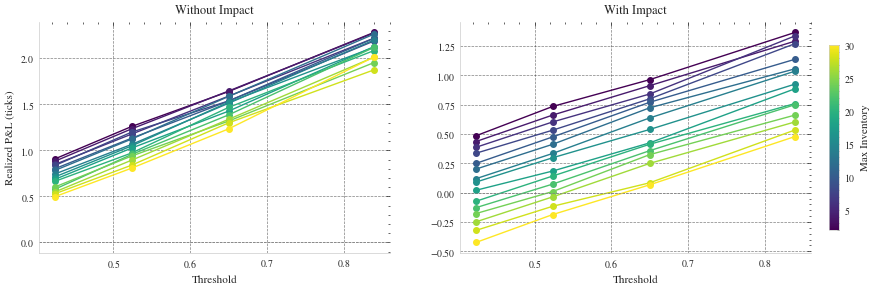

In [183]:
def plot_pnl_vs_threshold(df_no_impact, df_impact, q_max):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

    max_inventories = sorted(
        df_no_impact.filter(pl.col("q_max") == q_max)["max_inventory"]
        .unique()
        .to_list()
    )
    norm = mcolors.Normalize(vmin=min(max_inventories), vmax=max(max_inventories))
    cmap = cm.viridis

    for ax, df, title in [
        (ax1, df_no_impact, "Without Impact"),
        (ax2, df_impact, "With Impact"),
    ]:
        sub = df.filter(pl.col("q_max") == q_max)
        for inv in max_inventories:
            s = sub.filter(pl.col("max_inventory") == inv).sort("threshold")
            ax.plot(
                s["threshold"],
                s["edge_per_share"],
                color=cmap(norm(inv)),
                lw=1,
                marker="o",
                markersize=4,
            )
        ax.axhline(0, color="grey", lw=0.5, ls="--")
        ax.set_xlabel("Threshold", fontsize=8)
        ax.set_title(title, fontsize=9)
        ax.tick_params(labelsize=7)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    ax1.set_ylabel("Realized P&L (ticks)", fontsize=8)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.8, pad=0.02)
    cbar.set_label("Max Inventory", fontsize=8)
    cbar.ax.tick_params(labelsize=7)
    plt.show()


plot_pnl_vs_threshold(pnl_no_impact, pnl_impact, q_max=3)

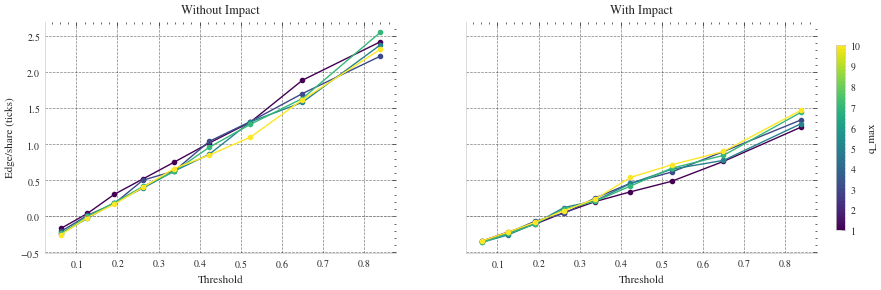

In [129]:
def plot_pnl_vs_threshold(df_no_impact, df_impact, max_inv):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

    q_maxes = sorted(
        df_no_impact.filter(pl.col("max_inventory") == max_inv)["q_max"]
        .unique()
        .to_list()
    )
    norm = mcolors.Normalize(vmin=min(q_maxes), vmax=max(q_maxes))
    cmap = cm.viridis

    for ax, df, title in [
        (ax1, df_no_impact, "Without Impact"),
        (ax2, df_impact, "With Impact"),
    ]:
        sub = df.filter(pl.col("max_inventory") == max_inv)
        for q in q_maxes:
            curve = sub.filter(pl.col("q_max") == q).sort("threshold")
            ax.plot(
                curve["threshold"],
                curve["edge_per_share"],
                marker="o",
                markersize=3,
                color=cmap(norm(q)),
                lw=1,
            )
        ax.axhline(0, color="grey", lw=0.5, ls="--")
        ax.set_xlabel("Threshold", fontsize=8)
        ax.set_title(title, fontsize=9)
        ax.tick_params(labelsize=7)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    ax1.set_ylabel("Edge/share (ticks)", fontsize=8)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.8, pad=0.02)
    cbar.set_label("q_max", fontsize=8)
    cbar.ax.tick_params(labelsize=7)
    # fig.tight_layout(pad=0.3)
    plt.show()


plot_pnl_vs_threshold(pnl_no_impact, pnl_impact, max_inv=10)

In [135]:
pnl_impact

q_max,max_inventory,threshold,n_trades,total_volume,n_round_trips,realized_pnl,volume_at_last_zero,edge_per_share,final_inventory,final_pnl,elapsed_s
i32,i32,f64,i64,i64,i64,f64,i64,f64,i32,f64,i64
1,5,0.0631,335355,335355,33056,-103135.0,335350,-0.307544,5,-112810.0,44
1,5,0.1267,200159,200159,19880,-36191.0,200154,-0.180816,5,-44896.0,44
1,5,0.1924,138851,138851,13784,-8042.0,138846,-0.05792,-5,-862.0,44
1,5,0.2619,106381,106381,10600,7115.0,106376,0.066885,5,-610.0,44
1,5,0.3382,80189,80189,7994,21024.0,80184,0.262197,-5,33856.0,44
…,…,…,…,…,…,…,…,…,…,…,…
10,60,0.3382,142518,936252,1289,-572914.0,934178,-0.613281,60,-698521.0,26
10,60,0.4237,112533,738068,987,-338197.0,735440,-0.459857,-60,-205046.0,26
10,60,0.5237,86319,566804,773,-125278.0,566744,-0.221049,60,-199312.0,26
